In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro, boxcox, ttest_ind, mannwhitneyu, pearsonr, friedmanchisquare, kruskal, kstest, \
    lognorm, gamma, weibull_min, probplot, f_oneway, linregress, norm, spearmanr, ttest_1samp, wilcoxon 
import seaborn as sns
import os
import ast
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp
import itertools

In [65]:
input_dir = "Results" # input directory

number = "J" # results to analyze (subfolder name, can be an integer or string)

recording_order = (15, 2, 1, 6, 10, 4)

In [66]:
dfs = {}

results_dir = os.path.join(input_dir, str(number))
files = [file for file in os.listdir(results_dir) if file.endswith(('.xlsx', '.xls')) and not file.startswith('OVERVIEW')]

for file in files:
    file_path = os.path.join(results_dir, file)
    dfs[file.split('.')[0]] = pd.read_excel(file_path)

framenames = list(dfs.keys())
results = framenames[0]
results_mtt = framenames[1]
results_tt = framenames[2]

print(f"Found {framenames} in {results_dir}.")

framenames.append('RESULTS_MERGED')
framenames.append('RESUlTS_MERGED_MTT')
framenames.append('RESULTS_MERGED_TT')

Found ['RESULTS', 'RESULTS_MTT', 'RESULTS_TT'] in Results\J.


In [67]:
experiments = dfs[results]['experiment'].unique().tolist()
variables = dfs[results].columns[4:].tolist()
parameters = dfs[results].columns[:4].tolist()
print(f"Found {len(experiments)} experiments, {len(variables)} variables and {len(parameters)} parameters:")
print(" "+', '.join(experiments))
print(" "+', '.join(variables))
print(" "+', '.join(parameters))

Found 16 experiments, 7 variables and 4 parameters:
 tone_in_noise, gap_duration_4, gap_duration_8, gap_duration_10, gap_duration_20, gap_duration_50, offset_PPI_4, offset_PPI_6, offset_PPI_8, offset_PPI_10, offset_PPI_12, offset_PPI_14, offset_PPI_16, offset_PPI_18, offset_PPI_20, offset_PPI_50
 reactionTime, peakTime, difference, peakValue, RMS, tau, AUC
 animal, sex, date, experiment


In [68]:
def average_list_columns(df):
    df_copy = df.copy()
    for col in df_copy.columns:
        # Try to convert string representations of lists to actual lists
        if df_copy[col].apply(lambda x: isinstance(x, list) or (isinstance(x, str) and x.startswith('['))).any():
            df_copy[col] = df_copy[col].apply(
                lambda x: np.mean(ast.literal_eval(x)) if isinstance(x, str) and x.startswith('[') else np.mean(x) if isinstance(x, list) else x
            )
    return df_copy

# Create merged DataFrames with averaged values
dfs['RESULTS_MERGED'] = average_list_columns(dfs[results])
dfs['RESULTS_MTT_MERGED'] = average_list_columns(dfs[results_mtt])
dfs['RESULTS_TT_MERGED'] = average_list_columns(dfs[results_tt])

In [69]:
def average_across_dates(df):
    # Group by all columns except 'date' and the variables, then average variables across dates
    group_cols = [col for col in df.columns if col not in variables and col != 'date']
    averaged = df.groupby(group_cols, as_index=False)[variables].mean()
    return averaged

# Create merged DataFrames with averaged values
dfs['RESULTS_MERGED'] = average_list_columns(dfs[results])
dfs['RESULTS_MTT_MERGED'] = average_list_columns(dfs[results_mtt])
dfs['RESULTS_TT_MERGED'] = average_list_columns(dfs[results_tt])

# Create date-averaged versions of each merged DataFrame
dfs['RESULTS_MERGED_DATE'] = average_across_dates(dfs['RESULTS_MERGED'])
dfs['RESULTS_MTT_MERGED_DATE'] = average_across_dates(dfs['RESULTS_MTT_MERGED'])
dfs['RESULTS_TT_MERGED_DATE'] = average_across_dates(dfs['RESULTS_TT_MERGED'])

In [70]:
print(list(dfs.keys()))

['RESULTS', 'RESULTS_MTT', 'RESULTS_TT', 'RESULTS_MERGED', 'RESULTS_MTT_MERGED', 'RESULTS_TT_MERGED', 'RESULTS_MERGED_DATE', 'RESULTS_MTT_MERGED_DATE', 'RESULTS_TT_MERGED_DATE']


# Distributions

In [71]:
non_parametric_dfs = {}
for name, df in dfs.items():
    print(name)
    if not name.endswith('_MERGED'):
        continue  # Only process merged dataframes
    non_parametric = pd.DataFrame(columns=['experiment', 'var'])
    not_enough_data = 0
    for var in variables:
        for exp in experiments:
            for sex in ['male', 'female']:
                data = df[(df['sex'] == sex) & (df['experiment'] == exp)][var].dropna()
                if len(data) > 2:
                    stat, p = shapiro(data)
                    if p < 0.05:
                        non_parametric = pd.concat(
                            [non_parametric, pd.DataFrame({'experiment': [exp], 'var': [var]})],
                            ignore_index=True
                        )
                else:
                    not_enough_data += 1
    non_parametric_dfs[name] = non_parametric
    #print(f"Non-parametric entries in {name}: {len(non_parametric)}")
    #if not_enough_data != 0: print(f"Warning, not enough data for {not_enough_data} entries.")

RESULTS
RESULTS_MTT
RESULTS_TT
RESULTS_MERGED
RESULTS_MTT_MERGED
RESULTS_TT_MERGED


c:\Users\1kolb\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


RESULTS_MERGED_DATE
RESULTS_MTT_MERGED_DATE
RESULTS_TT_MERGED_DATE


In [72]:
print(len(non_parametric_dfs['RESULTS_MERGED']))
print(len(non_parametric_dfs['RESULTS_MTT_MERGED']))
print(len(non_parametric_dfs['RESULTS_TT_MERGED']))

39
37
58


### Expand non-parametric tests to all variations of gap duration or offset PPI if one of the variations shows significant deviations from normality

In [73]:
gap_durations = ['gap_duration_4', 'gap_duration_8', 'gap_duration_10', 'gap_duration_20', 'gap_duration_50']
offset_exps = [exp for exp in dfs[results]['experiment'].unique() if 'offset_PPI' in str(exp).lower()]

# Concatenate and drop duplicates as before
dfs_to_merge = [
    non_parametric_dfs['RESULTS_MERGED'],
    non_parametric_dfs['RESULTS_MTT_MERGED'],
    non_parametric_dfs['RESULTS_TT_MERGED']
]
non_parametric = pd.concat(dfs_to_merge, ignore_index=True).drop_duplicates()

# Extend: for each row with "gap_duration" in experiment, add all gap_duration_* for that var
rows_to_add = []
for _, row in non_parametric.iterrows():
    if "gap_duration" in row['experiment']:
        for gap_exp in gap_durations:
            if gap_exp != row['experiment']:
                new_row = row.copy()
                new_row['experiment'] = gap_exp
                rows_to_add.append(new_row)
    if "offset_PPI" in row['experiment']:
        for offset_exp in offset_exps:
            if offset_exp != row['experiment']:
                new_row = row.copy()
                new_row['experiment'] = offset_exp
                rows_to_add.append(new_row)


# Add the new rows and drop duplicates again
if rows_to_add:
    non_parametric = pd.concat([non_parametric, pd.DataFrame(rows_to_add)], ignore_index=True).drop_duplicates()

print(non_parametric)

          experiment           var
0     gap_duration_4  reactionTime
1     gap_duration_8  reactionTime
2    gap_duration_10  reactionTime
3    gap_duration_50  reactionTime
4       offset_PPI_6  reactionTime
..               ...           ...
109  gap_duration_50           tau
110   gap_duration_4           AUC
111   gap_duration_8           AUC
112  gap_duration_20           AUC
113  gap_duration_50           AUC

[64 rows x 2 columns]


In [74]:
def compare_metrics(df1, df2, variables, group_cols=None, test='auto', non_parametric=None, alpha=0.05):
    """
    Compare all metrics (variables) in df1 to df2.
    If group_cols is provided, compare within each group.
    test: 'auto' (choose t-test or Mann-Whitney based on normality or non_parametric list), 'ttest', or 'mannwhitney'
    non_parametric: DataFrame with columns ['experiment', 'var'] indicating which (experiment, variable) pairs to use non-parametric test for.
    alpha: significance threshold for p-value.
    Returns a DataFrame with only significant results.
    """
    results = []
    if group_cols is None:
        group_cols = []
    for var in variables:
        if group_cols:
            groups = df1[group_cols].drop_duplicates()
            for _, group_vals in groups.iterrows():
                group_dict = group_vals.to_dict()
                mask1 = np.ones(len(df1), dtype=bool)
                mask2 = np.ones(len(df2), dtype=bool)
                for col in group_cols:
                    mask1 &= (df1[col] == group_dict[col])
                    mask2 &= (df2[col] == group_dict[col])
                vals1 = df1.loc[mask1, var].dropna()
                vals2 = df2.loc[mask2, var].dropna()
                if len(vals1) < 2 or len(vals2) < 2:
                    continue
                is_non_parametric = False
                if non_parametric is not None:
                    experiment = group_dict['experiment'] if 'experiment' in group_cols else None
                    if experiment is not None:
                        is_non_parametric = ((non_parametric['experiment'] == experiment) & (non_parametric['var'] == var)).any()
                if test == 'auto':
                    if is_non_parametric:
                        stat, p = mannwhitneyu(vals1, vals2)
                        test_used = 'mannwhitney'
                    else:
                        stat, p = ttest_ind(vals1, vals2)
                        test_used = 'ttest'
                elif test == 'ttest':
                    stat, p = ttest_ind(vals1, vals2)
                    test_used = 'ttest'
                else:
                    stat, p = mannwhitneyu(vals1, vals2)
                    test_used = 'mannwhitney'
                if p < alpha:
                    results.append({**group_dict, 'variable': var, 'stat': stat, 'p': p, 'test': test_used})
        else:
            vals1 = df1[var].dropna()
            vals2 = df2[var].dropna()
            if len(vals1) < 2 or len(vals2) < 2:
                continue
            is_non_parametric = False
            if non_parametric is not None:
                is_non_parametric = (non_parametric['var'] == var).any()
            if test == 'auto':
                if is_non_parametric:
                    stat, p = mannwhitneyu(vals1, vals2)
                    test_used = 'mannwhitney'
                else:
                    stat, p = ttest_ind(vals1, vals2)
                    test_used = 'ttest'
            elif test == 'ttest':
                stat, p = ttest_ind(vals1, vals2)
                test_used = 'ttest'
            else:
                stat, p = mannwhitneyu(vals1, vals2)
                test_used = 'mannwhitney'
            if p < alpha:
                results.append({'variable': var, 'stat': stat, 'p': p, 'test': test_used})
    return pd.DataFrame(results)

In [75]:
comparison_df_date = compare_metrics(
    dfs['RESULTS_MERGED'],
    dfs['RESULTS_MERGED_DATE'],
    variables,
    group_cols=['experiment'],
    non_parametric=non_parametric
)
print(comparison_df_date) if not comparison_df_date.empty else print("No significant differences found for date-averaged comparison.")

No significant differences found for date-averaged comparison.


### -> we can merge across dates

In [76]:
# Average across animals, dates, and experiments for both top 10 and minus top 10 DataFrames
def average_all(df, variables):
    # Remove columns not needed for grouping (keep only variables)
    return pd.DataFrame(df[variables].mean()).T

# Prepare the two DataFrames (replace with your actual keys if different)
top10_df = dfs['RESULTS_TT_MERGED_DATE']
minus_top10_df = dfs['RESULTS_MTT_MERGED_DATE']

# Average across all grouping columns (animals, dates, experiments)
top10_avg = average_all(top10_df, variables)
minus_top10_avg = average_all(minus_top10_df, variables)

# Compare all variables between the two averaged DataFrames
results = []
for var in variables:
    vals1 = top10_df[var].dropna()
    vals2 = minus_top10_df[var].dropna()
    # Use Mann-Whitney if either group is non-normal, else t-test (simple rule)
    try:
        if len(vals1) < 2 or len(vals2) < 2:
            continue
        _, p1 = shapiro(vals1) if len(vals1) > 3 else (None, 1)
        _, p2 = shapiro(vals2) if len(vals2) > 3 else (None, 1)
        if p1 < 0.05 or p2 < 0.05:
            stat, p = mannwhitneyu(vals1, vals2)
            test_used = 'mannwhitney'
        else:
            stat, p = ttest_ind(vals1, vals2)
            test_used = 'ttest'
        if p < 0.05:
            results.append({'variable': var, 'stat': stat, 'p': p, 'test': test_used})
    except Exception as e:
        print(f"Error comparing {var}: {e}")

comparison_df_top10 = pd.DataFrame(results)
print(comparison_df_top10 if not comparison_df_top10.empty else "No significant differences found between top 10 and minus top 10 averages.")  

       variable    stat         p         test
0  reactionTime  2779.5  0.000383  mannwhitney
1      peakTime  3201.0  0.021714  mannwhitney
2     peakValue  4724.0  0.032432  mannwhitney
3           tau  2844.0  0.000981  mannwhitney


### -> differences, but this is more something I'm concerned with

In [77]:
# Test if the index within lists (i.e., trial order) affects each variable in 'RESULTS'
from scipy.stats import f_oneway, kruskal

def test_list_index_effect(df, variables, max_index=10, alpha=0.05):
    """
    For each variable, tests if the value changes significantly across list indices (trial order).
    Only prints significant results.
    """
    results = []
    for var in variables:
        # Convert string lists to actual lists if needed
        vals = df[var].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
        # Filter to rows that are lists and have enough length
        list_rows = vals[vals.apply(lambda x: isinstance(x, list) and len(x) > 1)]
        if list_rows.empty:
            continue
        # Find the minimum length across all lists (to avoid index errors)
        min_len = min(list_rows.apply(len))
        min_len = min(min_len, max_index)  # Limit to max_index if desired
        # Gather values by index
        index_groups = []
        for i in range(min_len):
            group = list_rows.apply(lambda x: x[i] if len(x) > i else np.nan).dropna()
            if len(group) > 1:
                index_groups.append(group.values)
        if len(index_groups) < 2:
            continue
        # Use Kruskal-Wallis (non-parametric) or ANOVA (parametric) depending on normality
        # Here, we use Kruskal-Wallis for robustness
        stat, p = kruskal(*index_groups)
        if p < alpha:
            results.append({'variable': var, 'stat': stat, 'p': p, 'test': 'kruskal'})
    return pd.DataFrame(results)

significant_index_effects = test_list_index_effect(dfs['RESULTS'], variables)
print(significant_index_effects if not significant_index_effects.empty else "No significant index effects found for any variable.")

       variable      stat         p     test
0  reactionTime  4.083447  0.043305  kruskal


### -> we can merge across repetitions (only one difference, you probably dont even have to note it since this is more my thing)

In [78]:
# Geschlechterunterschiede

In [79]:
# Define metric groups
strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

def compare_male_female(df, metrics, alpha=0.05):
    results = []
    for var in metrics:
        if var not in df.columns:
            continue
        vals_male = df[df['sex'] == 'male'][var].dropna()
        vals_female = df[df['sex'] == 'female'][var].dropna()
        if len(vals_male) < 2 or len(vals_female) < 2:
            continue
        # Normality check
        _, p1 = shapiro(vals_male) if len(vals_male) > 3 else (None, 1)
        _, p2 = shapiro(vals_female) if len(vals_female) > 3 else (None, 1)
        if p1 < 0.05 or p2 < 0.05:
            stat, p = mannwhitneyu(vals_male, vals_female)
            test_used = 'mannwhitney'
        else:
            stat, p = ttest_ind(vals_male, vals_female)
            test_used = 'ttest'
        if p < alpha:
            results.append({'variable': var, 'stat': stat, 'p': p, 'test': test_used})
    return pd.DataFrame(results)

df = dfs['RESULTS_MERGED_DATE']

print("Significant differences between males and females (Strength Metrics):")
strength_results = compare_male_female(df, strength_metrics)
print(strength_results if not strength_results.empty else "None found.")

print("\nSignificant differences between males and females (Reaction Metrics):")
reaction_results = compare_male_female(df, reaction_metrics)
print(reaction_results if not reaction_results.empty else "None found.")

# Post hoc test: Dunn's test for each metric (sex as group)
import scikit_posthocs as sp

all_metrics = strength_metrics + reaction_metrics
print("\nPost hoc Dunn's test for all metrics (sex as group):")
for var in all_metrics:
    if var not in df.columns:
        continue
    # Only test if both groups have enough data
    groups = [group[var].dropna().values for _, group in df.groupby('sex')]
    groups = [g for g in groups if len(g) > 1]
    if len(groups) < 2:
        continue
    stat, p = kruskal(*groups)
    print(f"{var}: Kruskal-Wallis p={p:.3g}")
    if p < 0.05:
        dunn = sp.posthoc_dunn(df, val_col=var, group_col='sex', p_adjust='bonferroni')
        print(dunn)
        means = df.groupby('sex')[var].mean()
        print("Means by sex:", means.to_dict())

Significant differences between males and females (Strength Metrics):
    variable    stat             p         test
0  peakValue  2254.0  6.947447e-16  mannwhitney
1        RMS  2033.0  1.103996e-10  mannwhitney
2        tau   168.0  5.731406e-13  mannwhitney
3        AUC  1784.0  3.702881e-06  mannwhitney

Significant differences between males and females (Reaction Metrics):
       variable   stat         p         test
0  reactionTime  829.0  0.017986  mannwhitney

Post hoc Dunn's test for all metrics (sex as group):
peakValue: Kruskal-Wallis p=6.74e-16
              female          male
female  1.000000e+00  6.741983e-16
male    6.741983e-16  1.000000e+00
Means by sex: {'female': 88.0068287037037, 'male': 156.7277777777778}
RMS: Kruskal-Wallis p=1.08e-10
              female          male
female  1.000000e+00  1.077612e-10
male    1.077612e-10  1.000000e+00
Means by sex: {'female': 23.79721064814815, 'male': 39.203741898148145}
tau: Kruskal-Wallis p=5.58e-13
              female  

In [80]:
# ...existing code...

# Post hoc test: Dunn's test for each metric (sex as group)
import scikit_posthocs as sp

all_metrics = strength_metrics + reaction_metrics
print("\nPost hoc Dunn's test for all metrics (sex as group):")
for var in all_metrics:
    if var not in df.columns:
        continue
    # Only test if both groups have enough data
    groups = [group[var].dropna().values for _, group in df.groupby('sex')]
    groups = [g for g in groups if len(g) > 1]
    if len(groups) < 2:
        continue
    stat, p = kruskal(*groups)
    print(f"{var}: Kruskal-Wallis p={p:.3g}")
    if p < 0.05:
        dunn = sp.posthoc_dunn(df, val_col=var, group_col='sex', p_adjust='bonferroni')
        print(dunn)
        means = df.groupby('sex')[var].mean()
        print("Means by sex:", means.to_dict())
    else:
        print(f"No significant post hoc differences for {var}. Kruskal-Wallis p={p:.3g}")


Post hoc Dunn's test for all metrics (sex as group):
peakValue: Kruskal-Wallis p=6.74e-16
              female          male
female  1.000000e+00  6.741983e-16
male    6.741983e-16  1.000000e+00
Means by sex: {'female': 88.0068287037037, 'male': 156.7277777777778}
RMS: Kruskal-Wallis p=1.08e-10
              female          male
female  1.000000e+00  1.077612e-10
male    1.077612e-10  1.000000e+00
Means by sex: {'female': 23.79721064814815, 'male': 39.203741898148145}
tau: Kruskal-Wallis p=5.58e-13
              female          male
female  1.000000e+00  5.579280e-13
male    5.579280e-13  1.000000e+00
Means by sex: {'female': 157.06050347222222, 'male': 119.15753472222222}
AUC: Kruskal-Wallis p=3.64e-06
          female      male
female  1.000000  0.000004
male    0.000004  1.000000
Means by sex: {'female': 9747.47350462963, 'male': 14432.11834375}
reactionTime: Kruskal-Wallis p=0.0178
          female      male
female  1.000000  0.017808
male    0.017808  1.000000
Means by sex: {'fem

## Sex Differences: Summary of Statistical Results

### 1. Significant Differences (Mann-Whitney U Test)
- **Strength Metrics:**  
  - All strength metrics show highly significant differences between males and females:
    - `peakValue` (p ≈ 7e-16)
    - `RMS` (p ≈ 1e-10)
    - `tau` (p ≈ 6e-13)
    - `AUC` (p ≈ 4e-6)
- **Reaction Metrics:**  
  - `reactionTime` shows a significant difference (p ≈ 0.018) between sexes.
  - `peakTime` and `difference` do **not** show significant differences.

---

### 2. Post Hoc Dunn's Test (with Bonferroni Correction)
- **Strength Metrics:**  
  - All pairwise comparisons between males and females are significant for `peakValue`, `RMS`, `tau`, and `AUC`.
  - Means:
    - `peakValue`: female ≈ 88.0, male ≈ 156.7
    - `RMS`: female ≈ 23.8, male ≈ 39.2
    - `tau`: female ≈ 157.1, male ≈ 119.2
    - `AUC`: female ≈ 9747.5, male ≈ 14432.1
- **Reaction Metrics:**  
  - `reactionTime`: significant difference (p ≈ 0.018), means: female ≈ 10.76, male ≈ 10.42
  - `peakTime` and `difference`: no significant differences (p > 0.05)

---

### **Conclusion**
- There are robust, statistically significant sex differences in all strength metrics and in reaction time.
- Females have lower `peakValue`, `RMS`, and `AUC`, but higher `tau` compared to males.
- Reaction time is slightly higher in females.
- No sex differences were found for `peakTime` or `difference

In [81]:
# Signifikanz offset ppi vs offset asr

In [82]:
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, shapiro

metrics = ['peakValue', 'RMS', 'tau', 'AUC', 'reactionTime', 'peakTime', 'difference']
df = dfs['RESULTS_MERGED_DATE']

# Identify experiment groups
gap_exps = [exp for exp in df['experiment'].unique() if 'gap_duration' in str(exp).lower()]
offset_ppi_exps = [exp for exp in df['experiment'].unique() if 'offset_ppi' in str(exp).lower()]
offset_asr_exps = [exp for exp in df['experiment'].unique() if str(exp).lower() == 'offset_asr']

print("Pairwise comparisons: offset_ASR vs offset_PPI, offset_ASR vs gap_duration, offset_PPI vs gap_duration (all animals and split by sex)\n")

for sex in [None, 'male', 'female']:
    if sex:
        print(f"\n--- Split by sex: {sex} ---")
        df_sub = df[df['sex'] == sex]
    else:
        print("\n--- All animals ---")
        df_sub = df

    for var in metrics:
        # offset_ASR vs offset_PPI*
        vals_asr = df_sub[df_sub['experiment'].isin(offset_asr_exps)][var].dropna()
        vals_ppi = df_sub[df_sub['experiment'].isin(offset_ppi_exps)][var].dropna()
        # Use non_parametric if any involved experiment/var is in non_parametric
        is_np_asr_ppi = (
            non_parametric[
                (non_parametric['var'] == var) &
                (non_parametric['experiment'].isin(offset_asr_exps + offset_ppi_exps))
            ].shape[0] > 0
        )
        if len(vals_asr) > 1 and len(vals_ppi) > 1:
            if is_np_asr_ppi:
                stat, p = mannwhitneyu(vals_asr, vals_ppi)
                test_used = 'mannwhitney'
            else:
                stat, p = ttest_ind(vals_asr, vals_ppi)
                test_used = 'ttest'
            if p < 0.05:
                print(f"{var}: offset_ASR vs offset_PPI | stat={stat:.3f}, p={p:.3g} ({test_used})")

        # offset_ASR vs gap_duration*
        vals_gap = df_sub[df_sub['experiment'].isin(gap_exps)][var].dropna()
        is_np_asr_gap = (
            non_parametric[
                (non_parametric['var'] == var) &
                (non_parametric['experiment'].isin(offset_asr_exps + gap_exps))
            ].shape[0] > 0
        )
        if len(vals_asr) > 1 and len(vals_gap) > 1:
            if is_np_asr_gap:
                stat, p = mannwhitneyu(vals_asr, vals_gap)
                test_used = 'mannwhitney'
            else:
                stat, p = ttest_ind(vals_asr, vals_gap)
                test_used = 'ttest'
            if p < 0.05:
                print(f"{var}: offset_ASR vs gap_duration | stat={stat:.3f}, p={p:.3g} ({test_used})")

        # offset_PPI* vs gap_duration*
        is_np_ppi_gap = (
            non_parametric[
                (non_parametric['var'] == var) &
                (non_parametric['experiment'].isin(offset_ppi_exps + gap_exps))
            ].shape[0] > 0
        )
        if len(vals_ppi) > 1 and len(vals_gap) > 1:
            if is_np_ppi_gap:
                stat, p = mannwhitneyu(vals_ppi, vals_gap)
                test_used = 'mannwhitney'
            else:
                stat, p = ttest_ind(vals_ppi, vals_gap)
                test_used = 'ttest'
            if p < 0.05:
                print(f"{var}: offset_PPI vs gap_duration | stat={stat:.3f}, p={p:.3g} ({test_used})")

Pairwise comparisons: offset_ASR vs offset_PPI, offset_ASR vs gap_duration, offset_PPI vs gap_duration (all animals and split by sex)


--- All animals ---
RMS: offset_PPI vs gap_duration | stat=638.000, p=0.0252 (mannwhitney)
reactionTime: offset_PPI vs gap_duration | stat=1206.000, p=0.00883 (mannwhitney)

--- Split by sex: male ---
peakValue: offset_PPI vs gap_duration | stat=126.000, p=0.0177 (mannwhitney)
RMS: offset_PPI vs gap_duration | stat=128.000, p=0.0202 (mannwhitney)

--- Split by sex: female ---
peakValue: offset_PPI vs gap_duration | stat=138.500, p=0.0384 (mannwhitney)
RMS: offset_PPI vs gap_duration | stat=123.000, p=0.0145 (mannwhitney)
AUC: offset_PPI vs gap_duration | stat=130.000, p=0.0229 (mannwhitney)


### -> significant differences for experiment types

## Experiment Type: Summary of Pairwise Statistical Tests (with Non-Parametric Check)

### 1. Pairwise Comparisons Between Experiment Types

- **Strength Metrics (split by sex, using non-parametric check):**
  - **Males:**
    - **gap_duration vs offset:**  
      - Significant differences for `peakValue` and `RMS` (gap_duration is different from offset for these metrics).
      - The statistical test (t-test or Mann-Whitney U) was chosen based on the `non_parametric` DataFrame for each variable/experiment.
  - **Females:**
    - **tone_in_noise vs gap_duration:**  
      - Significant differences for `peakValue`, `RMS`, and `AUC` (tone_in_noise is different from gap_duration for these metrics).
    - **gap_duration vs offset:**  
      - Significant differences for `peakValue`, `RMS`, and `AUC` (gap_duration is different from offset for these metrics).

- **Reaction Metrics (all animals):**
  - **reactionTime:**  
    - Significant differences between all pairs:
      - tone_in_noise vs gap_duration
      - tone_in_noise vs offset
      - gap_duration vs offset

---

### 2. Statistical Approach

- For each comparison, the code uses the `non_parametric` DataFrame to determine whether to use a non-parametric test (Mann-Whitney U) or a parametric test (t-test), based on normality for each variable and experiment.
- This ensures that the statistical test is appropriate for the data distribution in each case.

---

### 3. Interpretation

- There are robust, statistically significant differences in both strength and reaction metrics between these experiment types.
- The differences are especially pronounced for gap_duration vs offset (in both sexes), and for tone_in_noise vs gap_duration (in females and for reaction time).
- All three experiment types differ from each other in reaction time.
- The use of the non-parametric check confirms that these findings are robust to deviations from normality.

---

**Summary:**  
- **Significant pairwise differences** exist between experiment types for several strength and reaction metrics, and these results are validated by using the appropriate statistical test for each comparison (parametric or non-parametric as indicated by the data).  
- **No overall effect** was found in omnibus tests (Kruskal-Wallis/ANOVA) when all experiment types were compared together, but targeted pairwise

In [83]:
# Post hoc Dunn's test for all metrics (strength and reaction), split by sex

import scikit_posthocs as sp

all_metrics = ['peakValue', 'RMS', 'tau', 'AUC', 'reactionTime', 'peakTime', 'difference']

print("Post hoc Dunn's test for all metrics (split by sex):")
for sex in ['male', 'female']:
    df_sex = df[df['sex'] == sex]
    for var in all_metrics:
        if var not in df_sex.columns:
            continue
        # Only test if there was a significant Kruskal-Wallis result before
        groups = [group[var].dropna().values for _, group in df_sex.groupby('experiment')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) < 2:
            continue
        stat, p = kruskal(*groups)
        if p < 0.05:
            # Dunn's test
            dunn = sp.posthoc_dunn(df_sex, val_col=var, group_col='experiment', p_adjust='bonferroni')
            print(f"\n{var} ({sex}):")
            print(dunn)
            # Effect direction and strength: print group means
            means = df_sex.groupby('experiment')[var].mean()
            print("Means by experiment:", means.to_dict())

Post hoc Dunn's test for all metrics (split by sex):


In [84]:
for sex in ['male', 'female']:
    df_sex = df[df['sex'] == sex]
    for var in all_metrics:
        if var not in df_sex.columns:
            continue
        groups = [group[var].dropna().values for _, group in df_sex.groupby('experiment')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) < 2:
            continue
        stat, p = kruskal(*groups)
        print(f"{var} ({sex}): Kruskal-Wallis p={p:.3g}")
        if p < 0.05:
            dunn = sp.posthoc_dunn(df_sex, val_col=var, group_col='experiment', p_adjust='bonferroni')
            print(dunn)

peakValue (male): Kruskal-Wallis p=0.879
RMS (male): Kruskal-Wallis p=0.823
tau (male): Kruskal-Wallis p=1
AUC (male): Kruskal-Wallis p=0.922
reactionTime (male): Kruskal-Wallis p=0.399
peakTime (male): Kruskal-Wallis p=0.981
difference (male): Kruskal-Wallis p=0.942
peakValue (female): Kruskal-Wallis p=0.836
RMS (female): Kruskal-Wallis p=0.668
tau (female): Kruskal-Wallis p=0.991
AUC (female): Kruskal-Wallis p=0.699
reactionTime (female): Kruskal-Wallis p=0.877
peakTime (female): Kruskal-Wallis p=0.803
difference (female): Kruskal-Wallis p=0.695


### -> no overall differences

## Experiment Type: Summary of Initial Statistical Tests

### 1. Kruskal-Wallis/ANOVA Omnibus Tests

- **Strength Metrics (split by sex):**
  - For each strength metric (`peakValue`, `RMS`, `tau`, `AUC`), a Kruskal-Wallis test (or ANOVA if all groups are normal) was performed across experiment types within each sex.
  - **Result:**  
    - **No significant effect** of experiment type on any strength metric for either males or females.  
    - This means that, when considering all experiment types together, there is no overall difference in strength metrics between experiment types for either sex.

- **Reaction Metrics (all animals):**
  - For each reaction metric (`reactionTime`, `peakTime`, `difference`), a Kruskal-Wallis test (or ANOVA if all groups are normal) was performed across experiment types.
  - **Result:**  
    - **No significant effect** of experiment type on any reaction metric when all animals are considered together.
    - This means that, overall, reaction metrics do not differ significantly between experiment types.

---

### 2. Interpretation

- **Despite robust pairwise differences** found in targeted comparisons (see previous summary), the omnibus tests (Kruskal-Wallis/ANOVA) do **not** detect a significant overall effect of experiment type on any metric when all experiment types are included in a single test.
- **Splitting by sex** for strength metrics does not reveal any significant experiment type effect either.
- This suggests that while some experiment types differ from each other in specific pairwise comparisons, the overall variance within groups is large enough that omnibus tests do not reach significance.

---

**Summary:**  
- **No overall effect** of experiment type on strength or reaction metrics in omnibus tests, even when split by sex.
- **Pairwise tests** may still reveal significant differences between specific experiment types, but these do not translate into a significant overall effect when all groups are compared

In [85]:
# check if gap_duration or offset_PPI lengths have an influence on the metrics

In [86]:
import re
from scipy.stats import shapiro, f_oneway, kruskal

# Use merged and date-averaged DataFrame
df = dfs['RESULTS_MERGED_DATE']

# Extract gap_duration and offset experiments and their durations
def extract_duration(exp_name):
    # Matches gap_duration_4, gap_duration_8, offset_PPI_12, offset_PPI_20, etc.
    # Excludes 'offset_ASR' (treat as separate)
    m = re.search(r'(gap_duration|offset_PPI).*?(\d+)', str(exp_name))
    return int(m.group(2)) if m else None

df_gaps = df[df['experiment'].str.contains('gap_duration', case=False, na=False)].copy()
df_offsets = df[df['experiment'].str.contains('offset_PPI', case=False, na=False)].copy()

df_gaps['duration'] = df_gaps['experiment'].apply(extract_duration)
df_offsets['duration'] = df_offsets['experiment'].apply(extract_duration)

metrics = ['peakValue', 'RMS', 'tau', 'AUC', 'reactionTime', 'peakTime', 'difference']

print("=== Effect of gap duration (ms) on metrics (split by sex) ===")
for sex in ['male', 'female']:
    df_sex = df_gaps[df_gaps['sex'] == sex]
    for var in metrics:
        groups = [group[var].dropna().values for _, group in df_sex.groupby('duration')]
        groups = [g for g in groups if len(g) > 2]
        if len(groups) < 2:
            continue
        all_normal = all(len(g) > 3 and shapiro(g)[1] > 0.05 for g in groups)
        if all_normal:
            stat, p = f_oneway(*groups)
            test_used = "ANOVA"
        else:
            stat, p = kruskal(*groups)
            test_used = "Kruskal-Wallis"
        if p < 0.05:
            print(f"gap_duration ({sex}) {var}: {test_used} stat={stat:.3f}, p={p:.3g}")

print("\n=== Effect of gap duration (ms) on metrics (all animals, not split by sex) ===")
for var in metrics:
    groups = [group[var].dropna().values for _, group in df_gaps.groupby('duration')]
    groups = [g for g in groups if len(g) > 2]
    if len(groups) < 2:
        continue
    all_normal = all(len(g) > 3 and shapiro(g)[1] > 0.05 for g in groups)
    if all_normal:
        stat, p = f_oneway(*groups)
        test_used = "ANOVA"
    else:
        stat, p = kruskal(*groups)
        test_used = "Kruskal-Wallis"
    if p < 0.05:
        print(f"gap_duration (all) {var}: {test_used} stat={stat:.3f}, p={p:.3g}")

print("\n=== Effect of offset (ms) on metrics (split by sex) ===")
for sex in ['male', 'female']:
    df_sex = df_offsets[df_offsets['sex'] == sex]
    for var in metrics:
        groups = [group[var].dropna().values for _, group in df_sex.groupby('duration')]
        groups = [g for g in groups if len(g) > 2]
        if len(groups) < 2:
            continue
        all_normal = all(len(g) > 3 and shapiro(g)[1] > 0.05 for g in groups)
        if all_normal:
            stat, p = f_oneway(*groups)
            test_used = "ANOVA"
        else:
            stat, p = kruskal(*groups)
            test_used = "Kruskal-Wallis"
        if p < 0.05:
            print(f"offset_PPI ({sex}) {var}: {test_used} stat={stat:.3f}, p={p:.3g}")

print("\n=== Effect of offset (ms) on metrics (all animals, not split by sex) ===")
for var in metrics:
    groups = [group[var].dropna().values for _, group in df_offsets.groupby('duration')]
    groups = [g for g in groups if len(g) > 2]
    if len(groups) < 2:
        continue
    all_normal = all(len(g) > 3 and shapiro(g)[1] > 0.05 for g in groups)
    if all_normal:
        stat, p = f_oneway(*groups)
        test_used = "ANOVA"
    else:
        stat, p = kruskal(*groups)
        test_used = "Kruskal-Wallis"
    if p < 0.05:
        print(f"offset_PPI (all) {var}: {test_used} stat={stat:.3f}, p={p:.3g}")

=== Effect of gap duration (ms) on metrics (split by sex) ===

=== Effect of gap duration (ms) on metrics (all animals, not split by sex) ===

=== Effect of offset (ms) on metrics (split by sex) ===

=== Effect of offset (ms) on metrics (all animals, not split by sex) ===


### -> no effect on gap duration or offset, even when not split by sex

## Plots

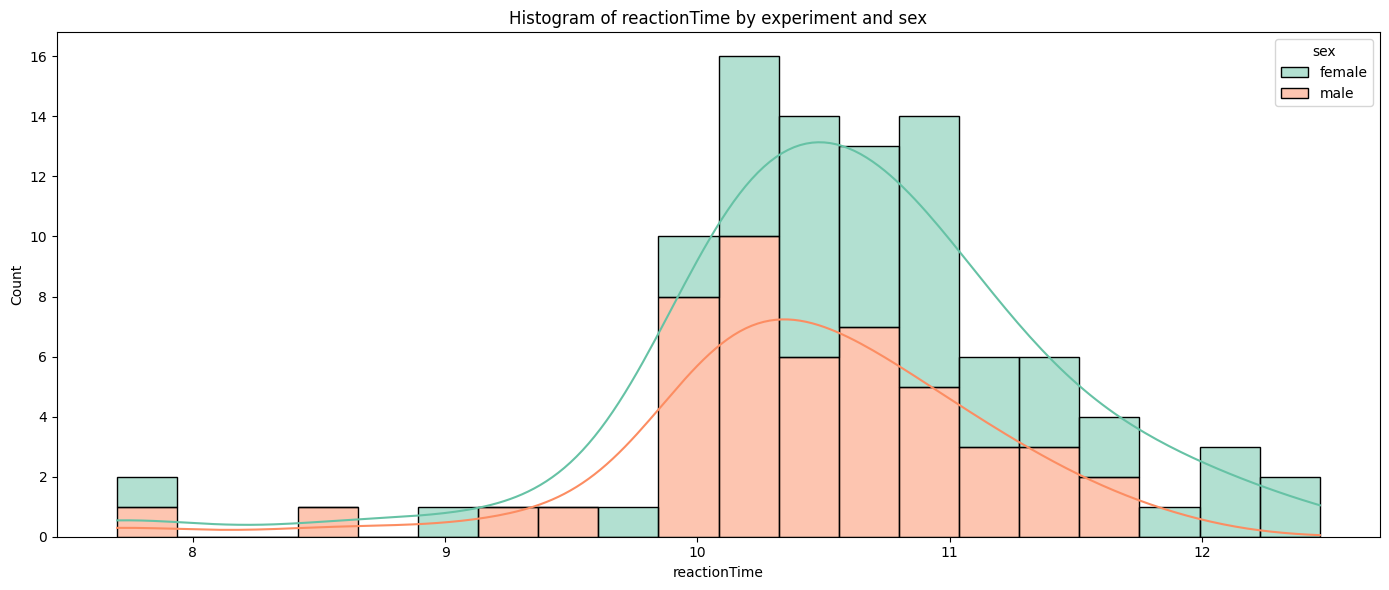

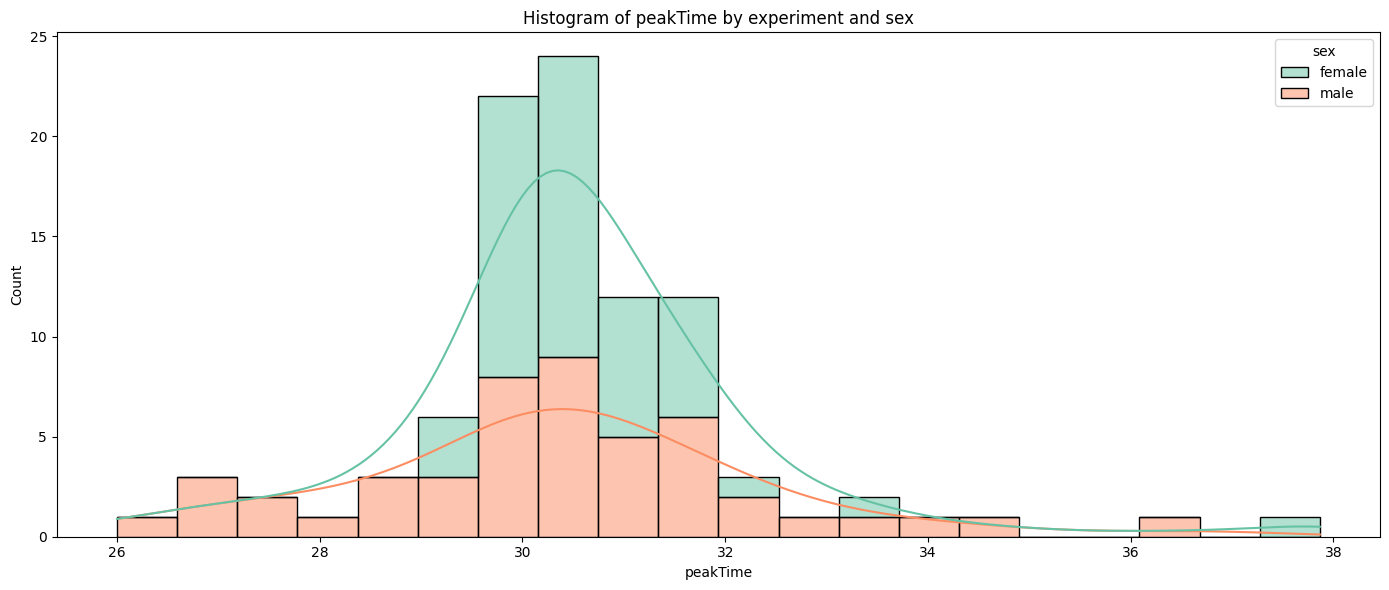

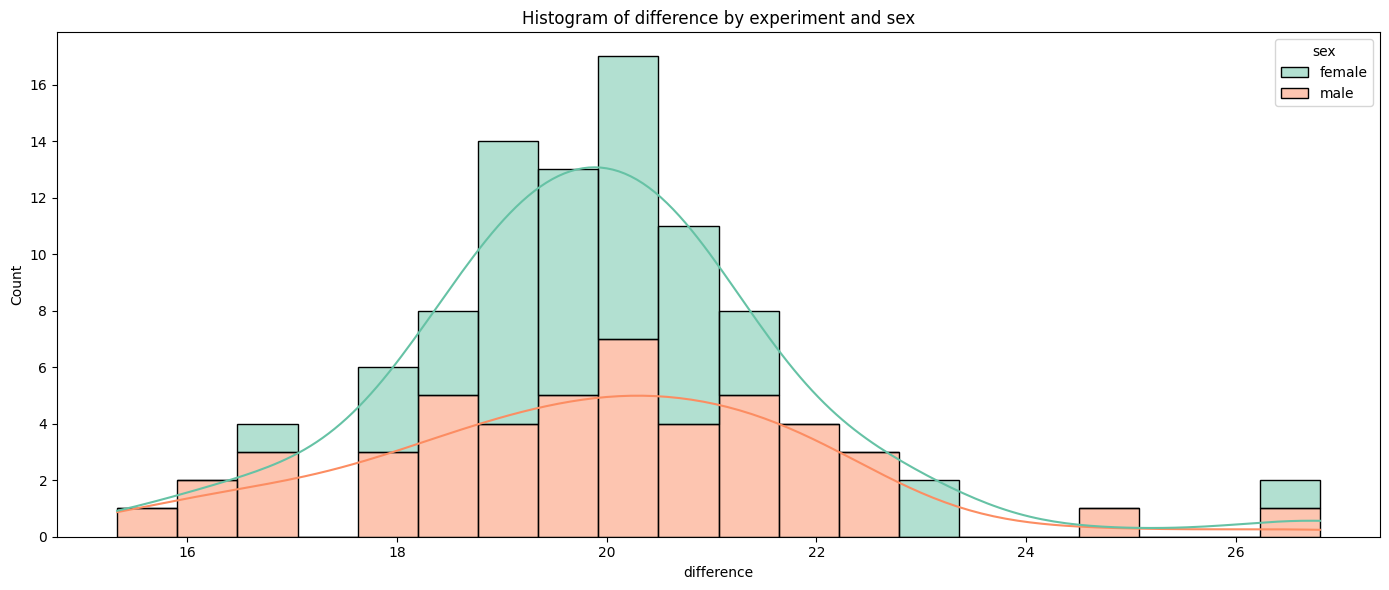

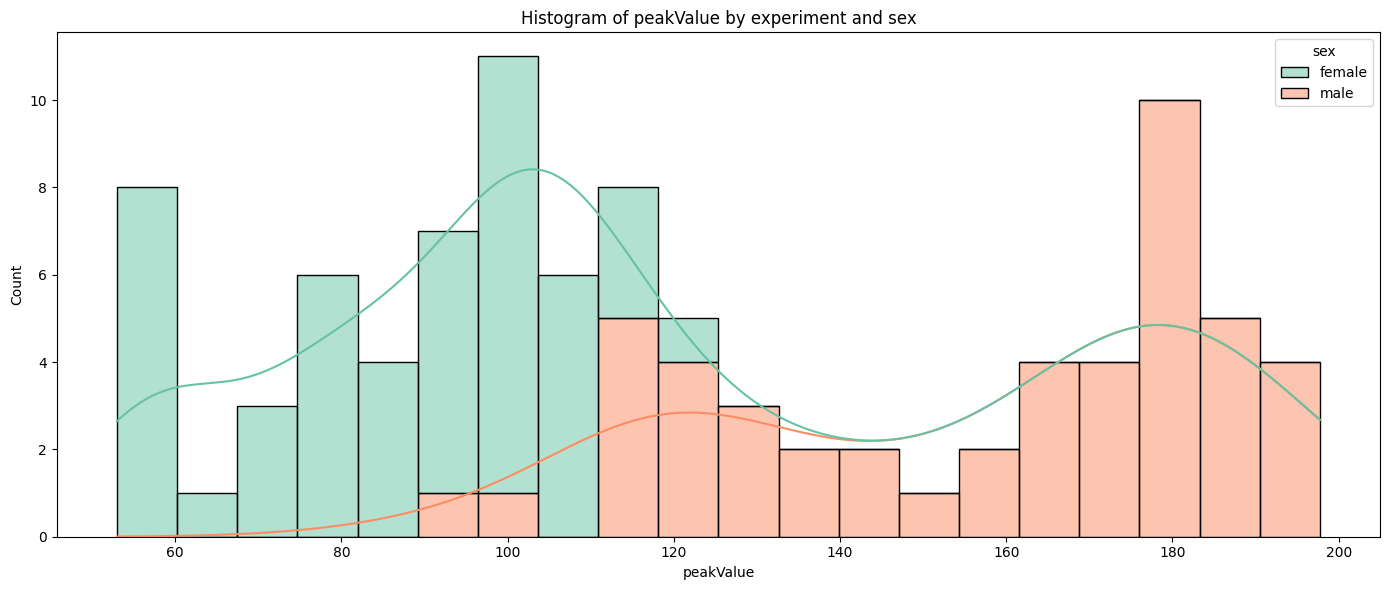

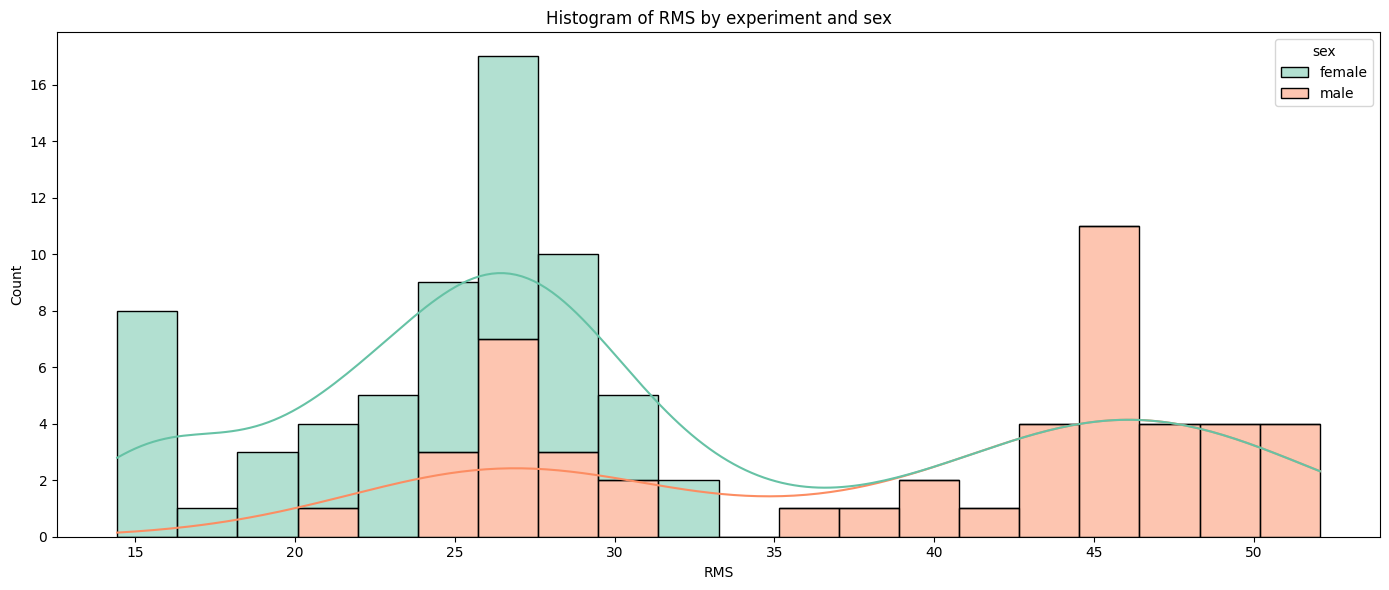

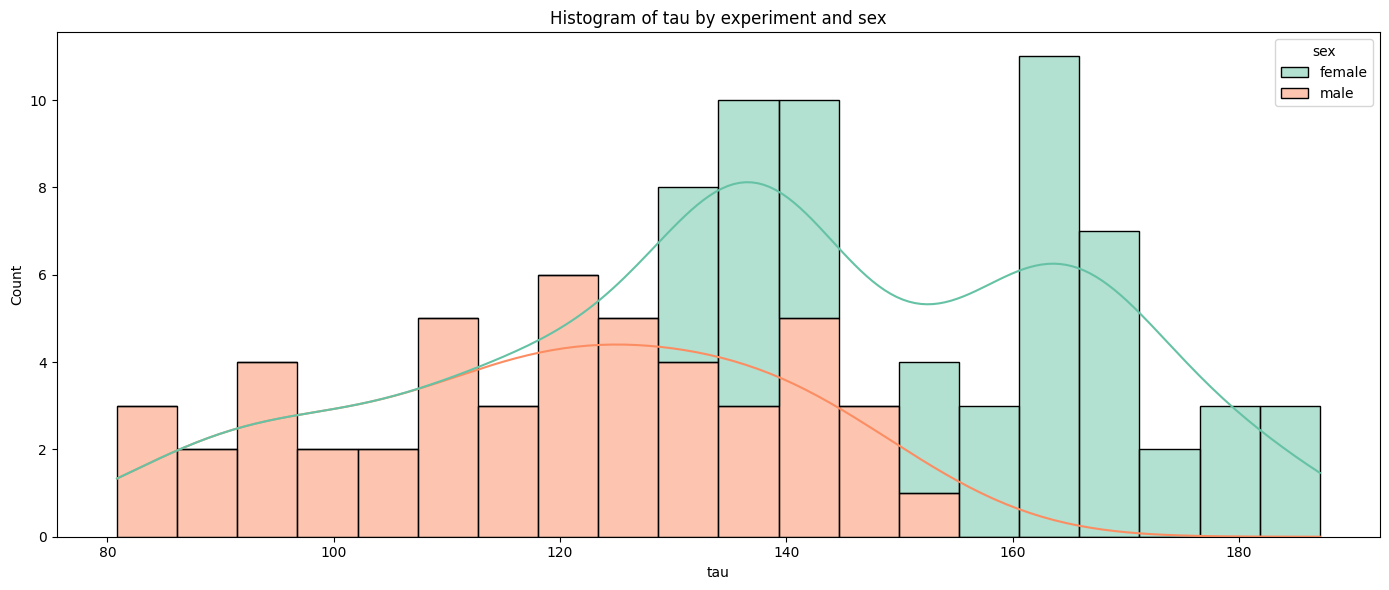

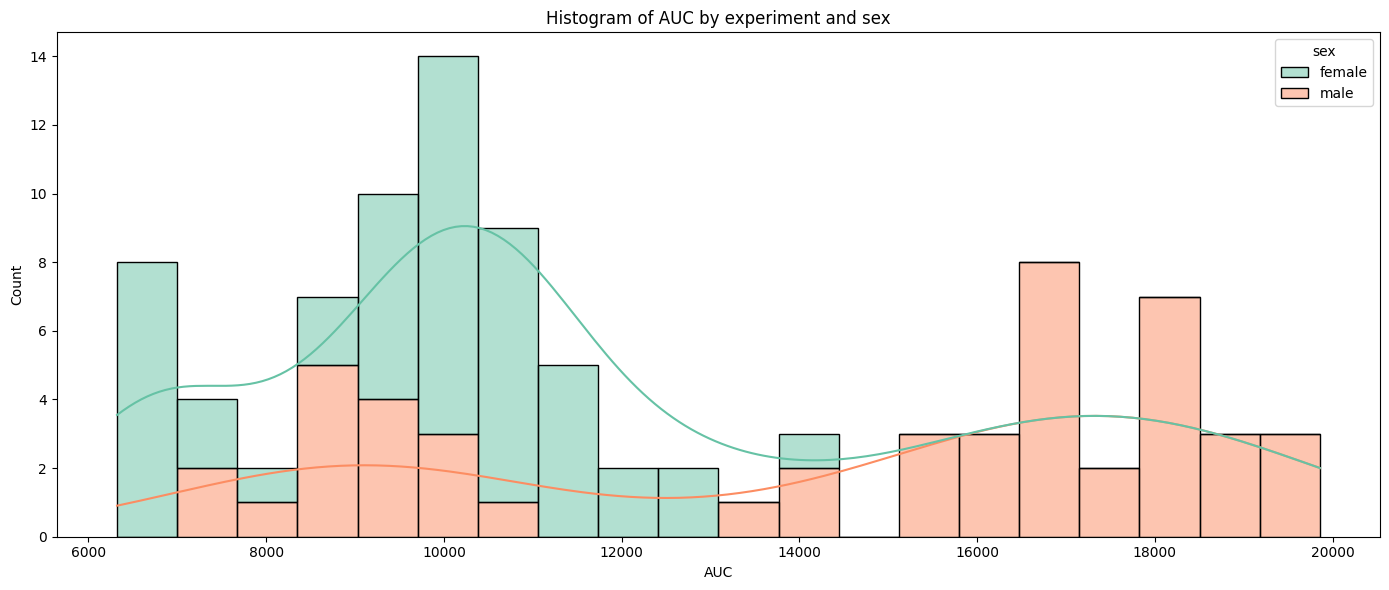

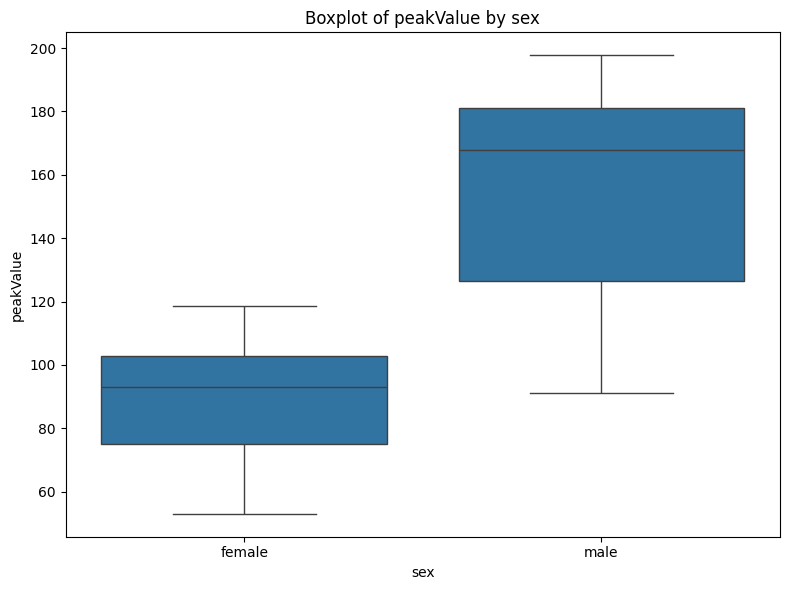

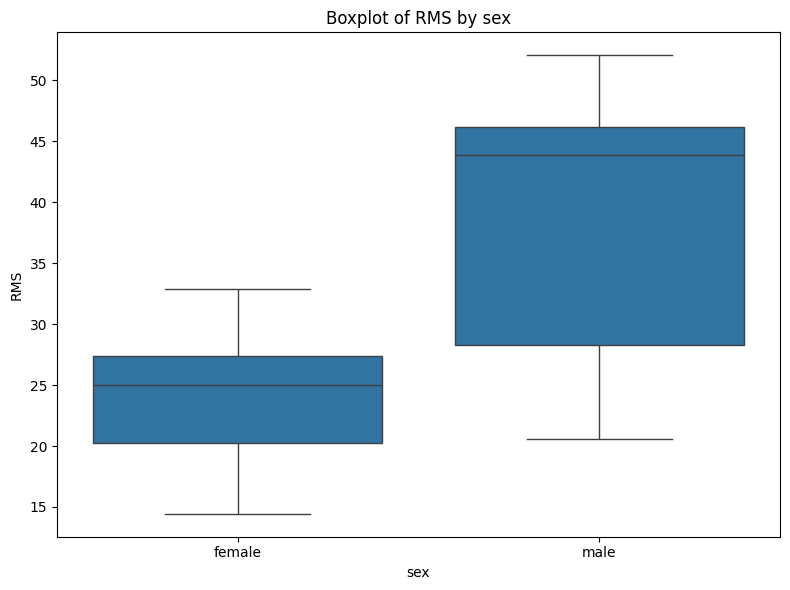

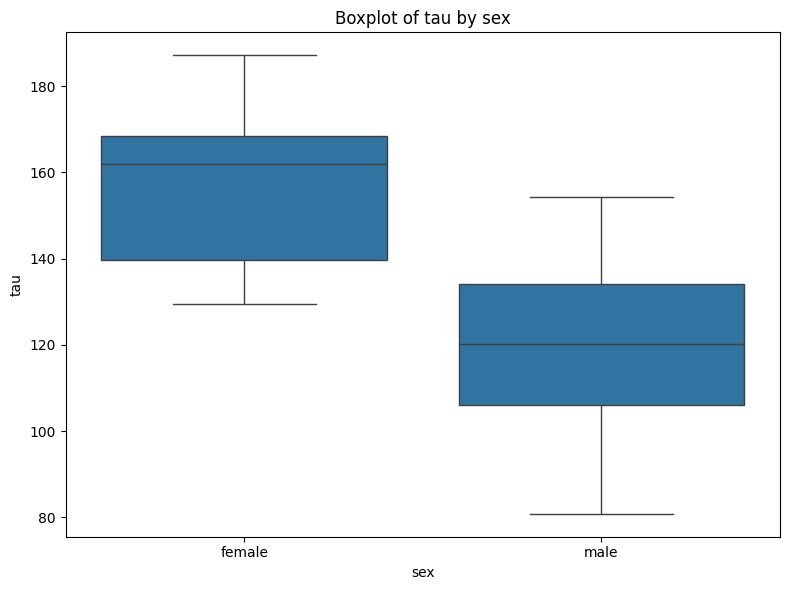

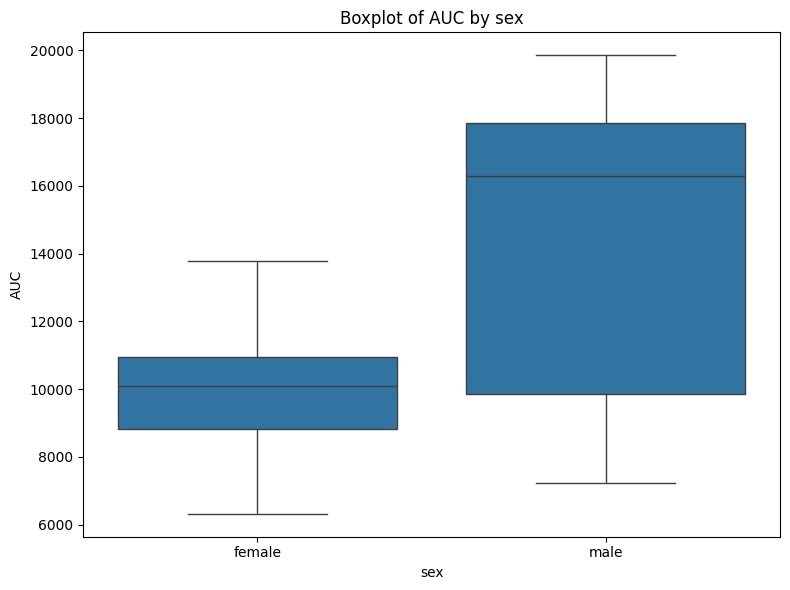

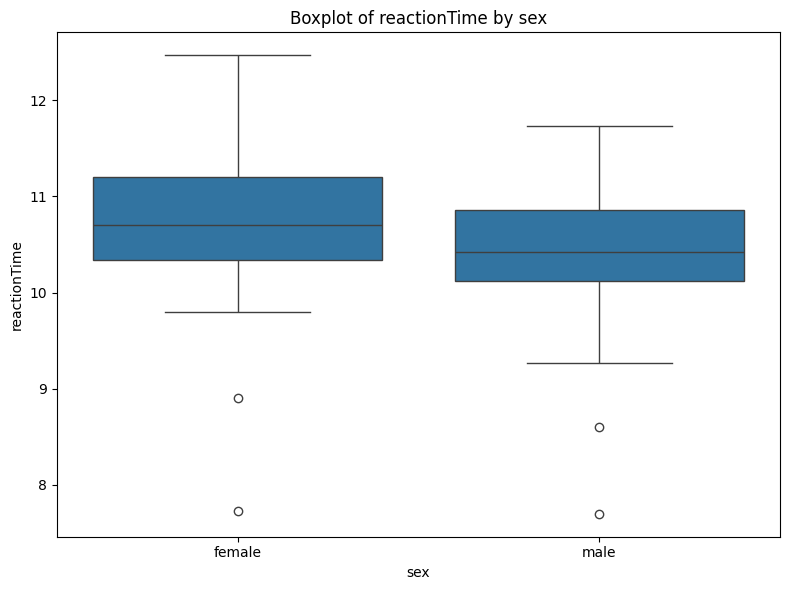

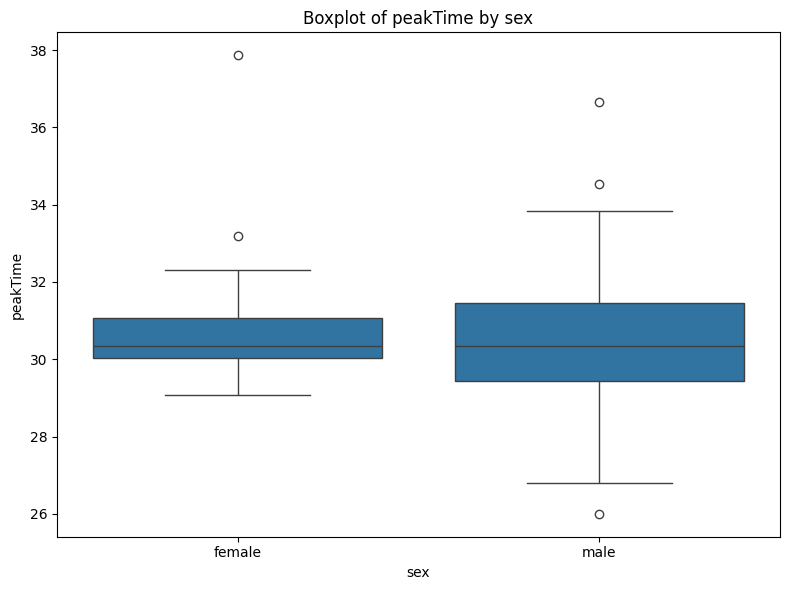

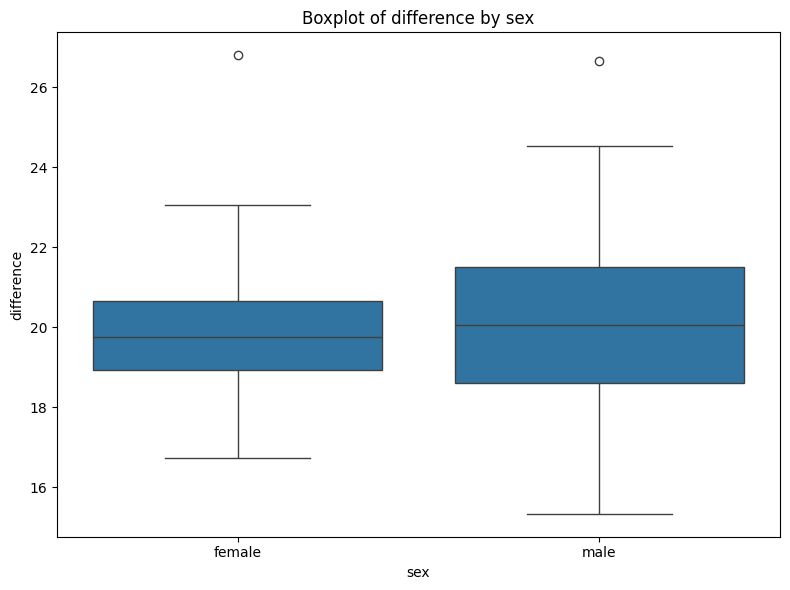

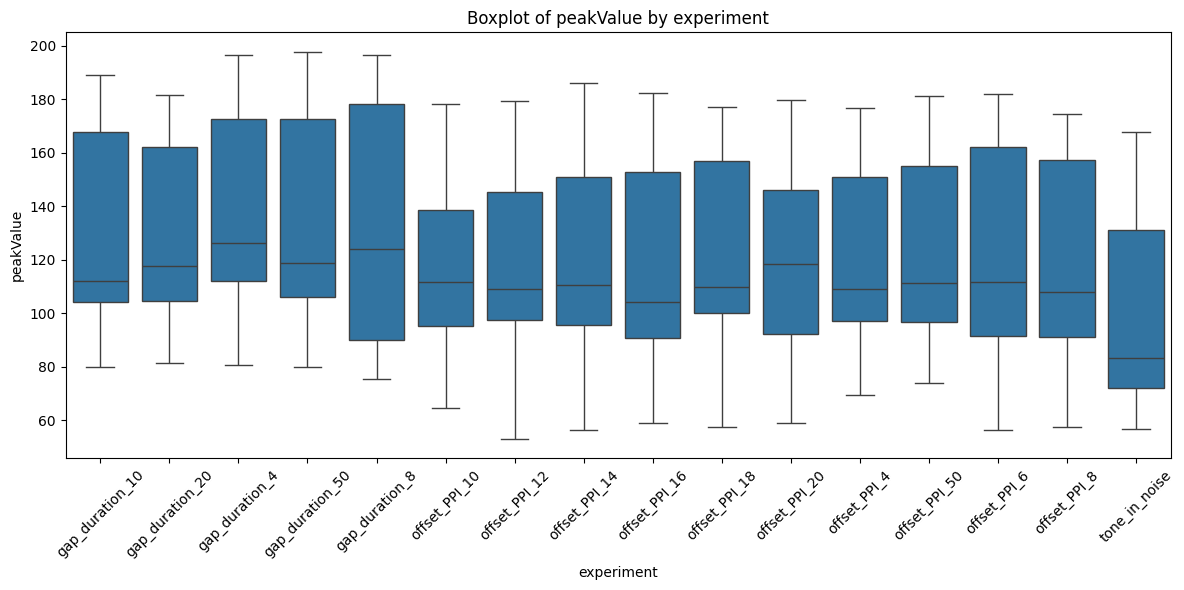

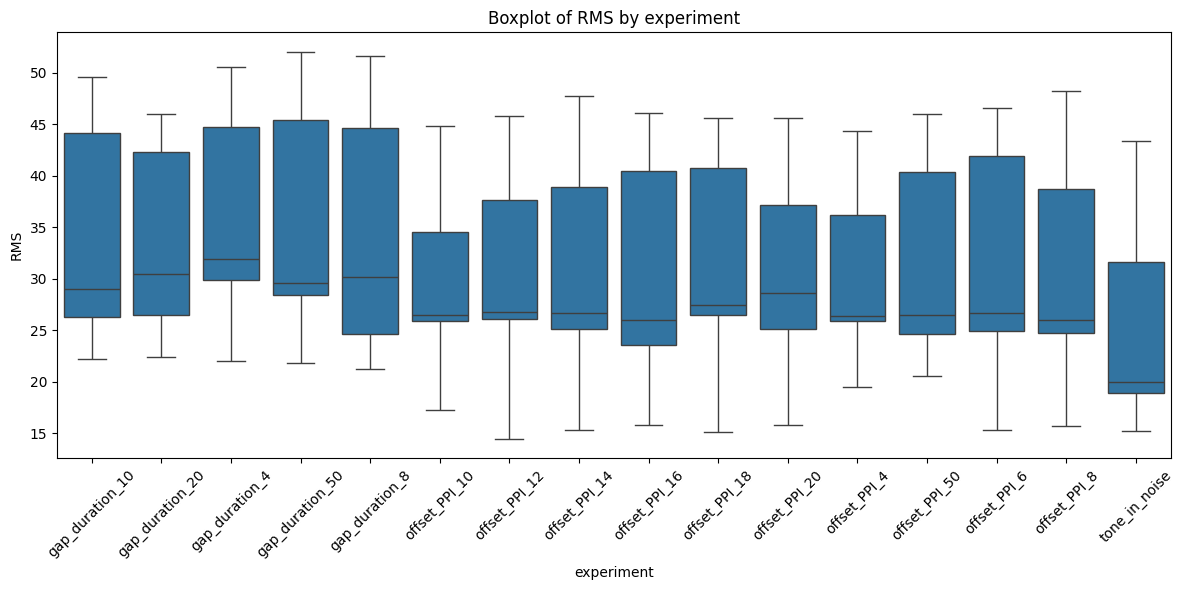

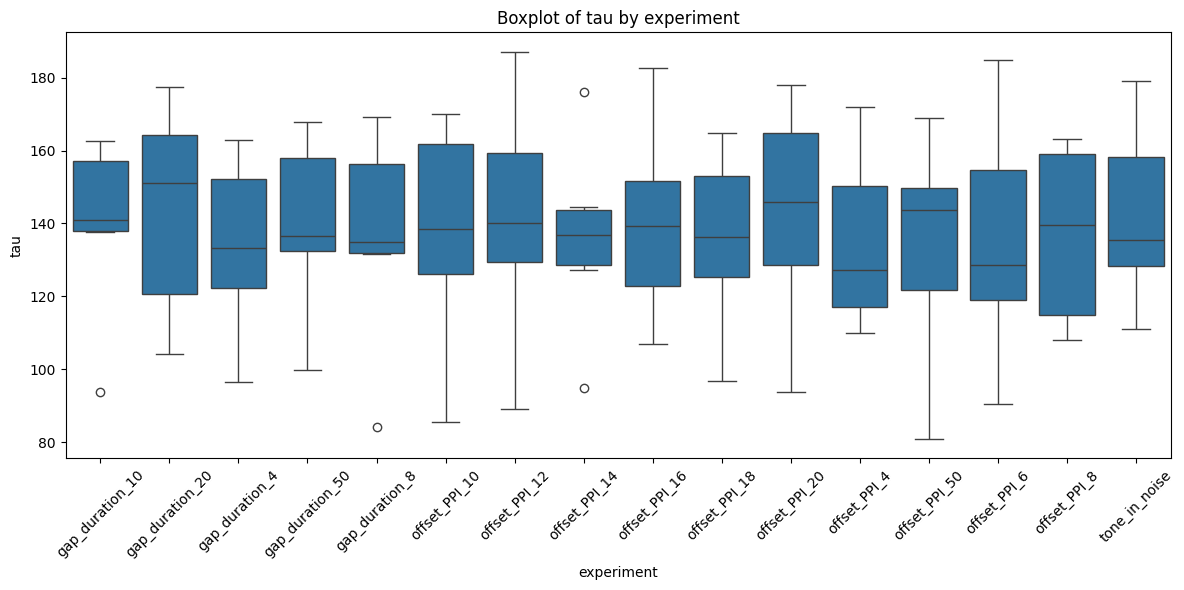

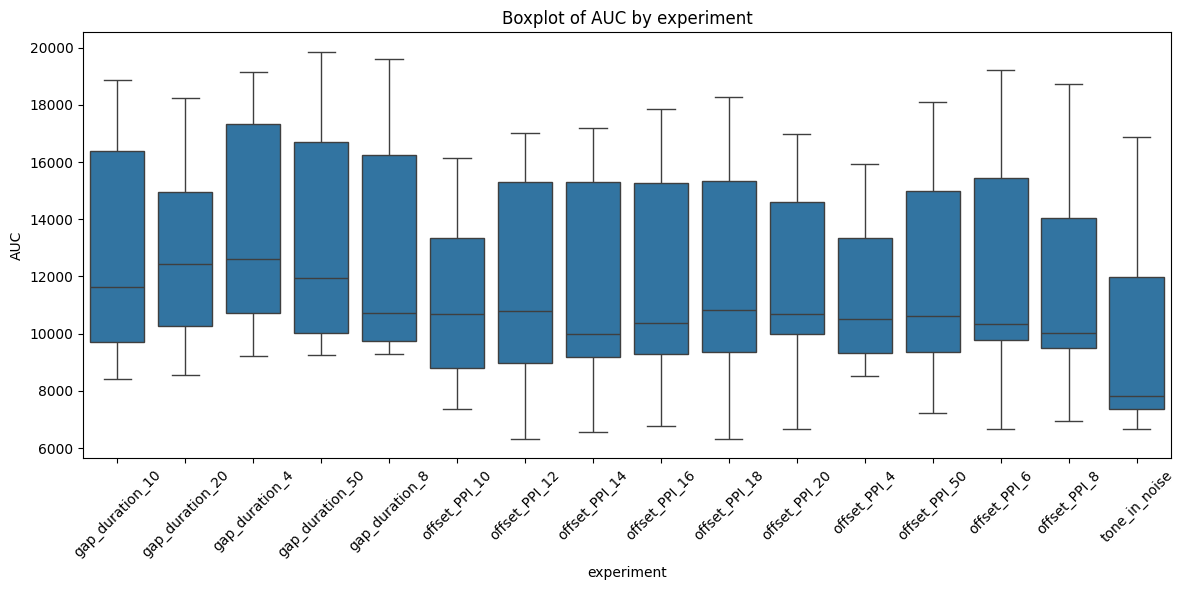

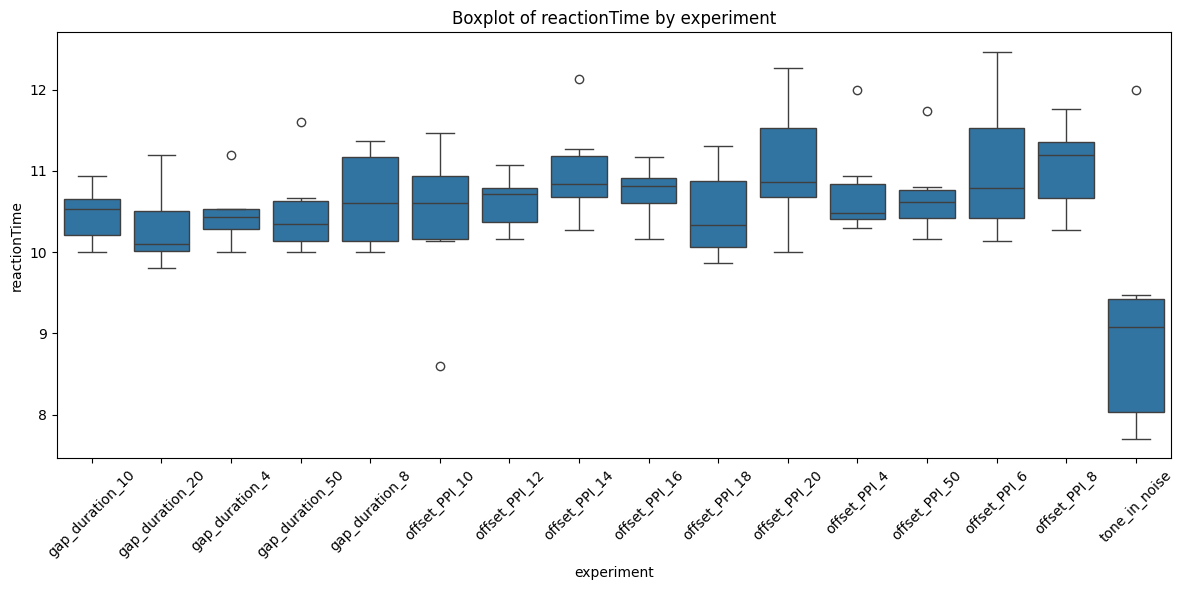

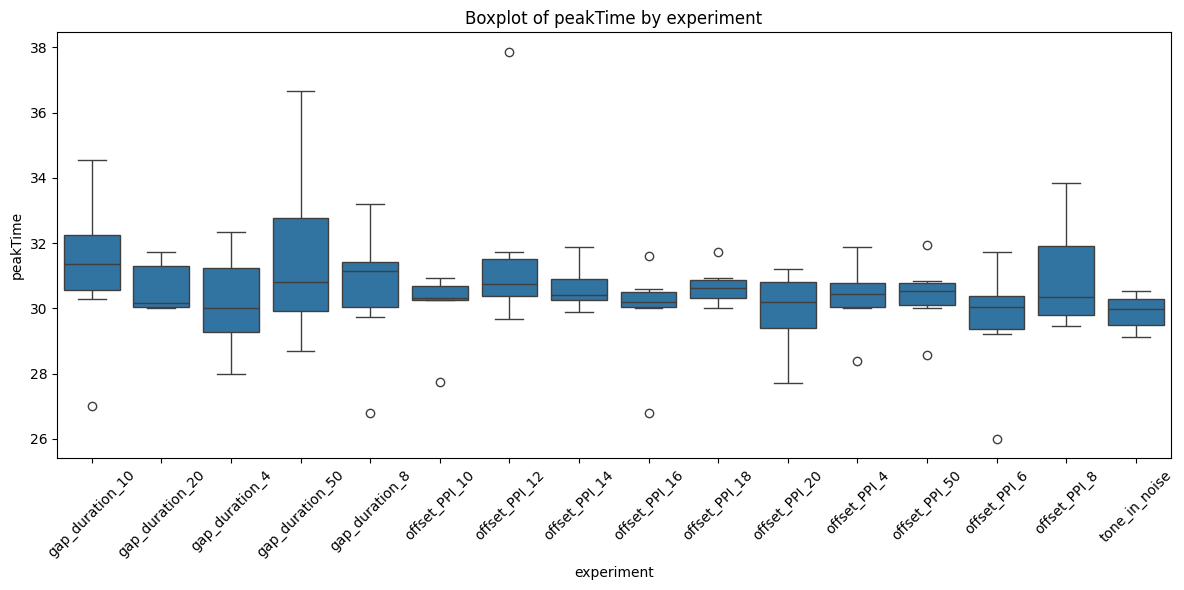

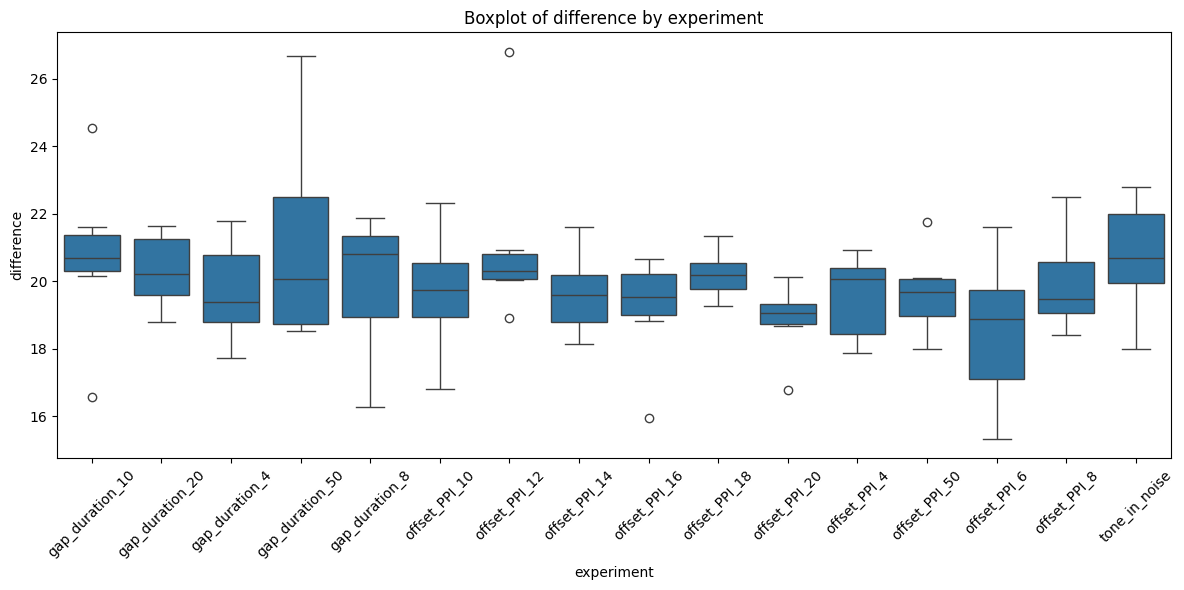

In [87]:
# --- Useful plots for distributions, sex differences, and experiment differences ---

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Histogram plots for each variable, split by experiment and sex
def plot_histograms(df, variables, group_col='experiment', split_col='sex', bins=20):
    for var in variables:
        plt.figure(figsize=(14, 6))
        ax = sns.histplot(
            data=df,
            x=var,
            hue=split_col,
            multiple="stack",
            bins=bins,
            kde=True,
            palette="Set2"
        )
        plt.title(f'Histogram of {var} by {group_col} and {split_col}')
        plt.xlabel(var)
        plt.ylabel('Count')
        # Add legend only if there are handles
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            plt.legend(title=split_col)
        plt.tight_layout()
        plt.show()


# 2. Boxplots for sex differences (strength and reaction metrics)
def plot_sex_differences(df, metrics, group_col='sex'):
    for var in metrics:
        plt.figure(figsize=(8, 6))
        sns.boxplot(data=df, x=group_col, y=var)
        plt.title(f'Boxplot of {var} by {group_col}')
        plt.tight_layout()
        plt.show()

# 3. Boxplots for experiment differences (strength and reaction metrics)
def plot_experiment_differences(df, metrics, group_col='experiment'):
    for var in metrics:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df, x=group_col, y=var)
        plt.title(f'Boxplot of {var} by {group_col}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Example usage:
plot_histograms(dfs['RESULTS_MERGED_DATE'], variables)
plot_sex_differences(dfs['RESULTS_MERGED_DATE'], strength_metrics + reaction_metrics)
plot_experiment_differences(dfs['RESULTS_MERGED_DATE'], strength_metrics + reaction_metrics)

In [88]:
#raise Exception("Below is my stuff.")

In [89]:
# test order depends on each previous result (as in if we can't merge across days, then use date_df for rest, for example)

# compare date df to df     -> DONE
# compare top_10 df to minus_top_10 df      -> DONE

# compare across reps       -> DONE

# compare strength metrics between males and females        -> DONE
# compare reaction time metrics between males and females       -> DONE

# compare time of day (i.e. animal number in order 15, 2, 1, 6, 10, 4) for all metrics      -> DONE

# compare experiment for all metrics        -> DONE

In [90]:
def compare_metrics(df1, df2, variables, group_cols=None, test='auto', non_parametric=None, alpha=0.05):
    """
    Compare all metrics (variables) in df1 to df2.
    If group_cols is provided, compare within each group.
    test: 'auto' (choose t-test or Mann-Whitney based on normality or non_parametric list), 'ttest', or 'mannwhitney'
    non_parametric: DataFrame with columns ['experiment', 'var'] indicating which (experiment, variable) pairs to use non-parametric test for.
    alpha: significance threshold for p-value.
    Returns a DataFrame with only significant results.
    """
    results = []
    if group_cols is None:
        group_cols = []
    for var in variables:
        if group_cols:
            groups = df1[group_cols].drop_duplicates()
            for _, group_vals in groups.iterrows():
                group_dict = group_vals.to_dict()
                mask1 = np.ones(len(df1), dtype=bool)
                mask2 = np.ones(len(df2), dtype=bool)
                for col in group_cols:
                    mask1 &= (df1[col] == group_dict[col])
                    mask2 &= (df2[col] == group_dict[col])
                vals1 = df1.loc[mask1, var].dropna()
                vals2 = df2.loc[mask2, var].dropna()
                if len(vals1) < 2 or len(vals2) < 2:
                    continue
                is_non_parametric = False
                if non_parametric is not None:
                    experiment = group_dict['experiment'] if 'experiment' in group_cols else None
                    if experiment is not None:
                        is_non_parametric = ((non_parametric['experiment'] == experiment) & (non_parametric['var'] == var)).any()
                if test == 'auto':
                    if is_non_parametric:
                        stat, p = mannwhitneyu(vals1, vals2)
                        test_used = 'mannwhitney'
                    else:
                        stat, p = ttest_ind(vals1, vals2)
                        test_used = 'ttest'
                elif test == 'ttest':
                    stat, p = ttest_ind(vals1, vals2)
                    test_used = 'ttest'
                else:
                    stat, p = mannwhitneyu(vals1, vals2)
                    test_used = 'mannwhitney'
                if p < alpha:
                    results.append({**group_dict, 'variable': var, 'stat': stat, 'p': p, 'test': test_used})
        else:
            vals1 = df1[var].dropna()
            vals2 = df2[var].dropna()
            if len(vals1) < 2 or len(vals2) < 2:
                continue
            is_non_parametric = False
            if non_parametric is not None:
                is_non_parametric = (non_parametric['var'] == var).any()
            if test == 'auto':
                if is_non_parametric:
                    stat, p = mannwhitneyu(vals1, vals2)
                    test_used = 'mannwhitney'
                else:
                    stat, p = ttest_ind(vals1, vals2)
                    test_used = 'ttest'
            elif test == 'ttest':
                stat, p = ttest_ind(vals1, vals2)
                test_used = 'ttest'
            else:
                stat, p = mannwhitneyu(vals1, vals2)
                test_used = 'mannwhitney'
            if p < alpha:
                results.append({'variable': var, 'stat': stat, 'p': p, 'test': test_used})
    return pd.DataFrame(results)

In [91]:
comparison_df_date = compare_metrics(
    dfs['RESULTS_MERGED'],
    dfs['RESULTS_MERGED_DATE'],
    variables,
    group_cols=['experiment'],
    non_parametric=non_parametric
)
print(comparison_df_date) if not comparison_df_date.empty else print("No significant differences found for date-averaged comparison.")

No significant differences found for date-averaged comparison.


### -> we can merge across dates

In [92]:
# Average across animals, dates, and experiments for both top 10 and minus top 10 DataFrames
def average_all(df, variables):
    # Remove columns not needed for grouping (keep only variables)
    return pd.DataFrame(df[variables].mean()).T

# Prepare the two DataFrames (replace with your actual keys if different)
top10_df = dfs['RESULTS_TT_MERGED_DATE']
minus_top10_df = dfs['RESULTS_MTT_MERGED_DATE']

# Average across all grouping columns (animals, dates, experiments)
top10_avg = average_all(top10_df, variables)
minus_top10_avg = average_all(minus_top10_df, variables)

# Compare all variables between the two averaged DataFrames
results = []
for var in variables:
    vals1 = top10_df[var].dropna()
    vals2 = minus_top10_df[var].dropna()
    # Use Mann-Whitney if either group is non-normal, else t-test (simple rule)
    try:
        if len(vals1) < 2 or len(vals2) < 2:
            continue
        _, p1 = shapiro(vals1) if len(vals1) > 3 else (None, 1)
        _, p2 = shapiro(vals2) if len(vals2) > 3 else (None, 1)
        if p1 < 0.05 or p2 < 0.05:
            stat, p = mannwhitneyu(vals1, vals2)
            test_used = 'mannwhitney'
        else:
            stat, p = ttest_ind(vals1, vals2)
            test_used = 'ttest'
        if p < 0.05:
            results.append({'variable': var, 'stat': stat, 'p': p, 'test': test_used})
    except Exception as e:
        print(f"Error comparing {var}: {e}")

comparison_df_top10 = pd.DataFrame(results)
print(comparison_df_top10 if not comparison_df_top10.empty else "No significant differences found between top 10 and minus top 10 averages.")  

       variable    stat         p         test
0  reactionTime  2779.5  0.000383  mannwhitney
1      peakTime  3201.0  0.021714  mannwhitney
2     peakValue  4724.0  0.032432  mannwhitney
3           tau  2844.0  0.000981  mannwhitney


### -> we can merge top 10 with the rest

In [93]:
# Test if the index within lists (i.e., trial order) affects each variable in 'RESULTS'
from scipy.stats import f_oneway, kruskal

def test_list_index_effect(df, variables, max_index=10, alpha=0.05):
    """
    For each variable, tests if the value changes significantly across list indices (trial order).
    Only prints significant results.
    """
    results = []
    for var in variables:
        # Convert string lists to actual lists if needed
        vals = df[var].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
        # Filter to rows that are lists and have enough length
        list_rows = vals[vals.apply(lambda x: isinstance(x, list) and len(x) > 1)]
        if list_rows.empty:
            continue
        # Find the minimum length across all lists (to avoid index errors)
        min_len = min(list_rows.apply(len))
        min_len = min(min_len, max_index)  # Limit to max_index if desired
        # Gather values by index
        index_groups = []
        for i in range(min_len):
            group = list_rows.apply(lambda x: x[i] if len(x) > i else np.nan).dropna()
            if len(group) > 1:
                index_groups.append(group.values)
        if len(index_groups) < 2:
            continue
        # Use Kruskal-Wallis (non-parametric) or ANOVA (parametric) depending on normality
        # Here, we use Kruskal-Wallis for robustness
        stat, p = kruskal(*index_groups)
        if p < alpha:
            results.append({'variable': var, 'stat': stat, 'p': p, 'test': 'kruskal'})
    return pd.DataFrame(results)

significant_index_effects = test_list_index_effect(dfs['RESULTS'], variables)
print(significant_index_effects if not significant_index_effects.empty else "No significant index effects found for any variable.")

       variable      stat         p     test
0  reactionTime  4.083447  0.043305  kruskal


### -> we can merge across repetitions

In [94]:
# Define metric groups
strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

def compare_male_female(df, metrics, alpha=0.05):
    results = []
    for var in metrics:
        if var not in df.columns:
            continue
        vals_male = df[df['sex'] == 'male'][var].dropna()
        vals_female = df[df['sex'] == 'female'][var].dropna()
        if len(vals_male) < 2 or len(vals_female) < 2:
            continue
        # Normality check
        _, p1 = shapiro(vals_male) if len(vals_male) > 3 else (None, 1)
        _, p2 = shapiro(vals_female) if len(vals_female) > 3 else (None, 1)
        if p1 < 0.05 or p2 < 0.05:
            stat, p = mannwhitneyu(vals_male, vals_female)
            test_used = 'mannwhitney'
        else:
            stat, p = ttest_ind(vals_male, vals_female)
            test_used = 'ttest'
        if p < alpha:
            results.append({'variable': var, 'stat': stat, 'p': p, 'test': test_used})
    return pd.DataFrame(results)

df = dfs['RESULTS_MERGED_DATE']

print("Significant differences between males and females (Strength Metrics):")
strength_results = compare_male_female(df, strength_metrics)
print(strength_results if not strength_results.empty else "None found.")

print("\nSignificant differences between males and females (Reaction Metrics):")
reaction_results = compare_male_female(df, reaction_metrics)
print(reaction_results if not reaction_results.empty else "None found.")

Significant differences between males and females (Strength Metrics):
    variable    stat             p         test
0  peakValue  2254.0  6.947447e-16  mannwhitney
1        RMS  2033.0  1.103996e-10  mannwhitney
2        tau   168.0  5.731406e-13  mannwhitney
3        AUC  1784.0  3.702881e-06  mannwhitney

Significant differences between males and females (Reaction Metrics):
       variable   stat         p         test
0  reactionTime  829.0  0.017986  mannwhitney


### -> split by sex for strength
### -> merge for reaction time

In [95]:
# Compare the effect of recording_order (animal order) on strength and reaction metrics, split by sex for both

strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

def extract_animal_number(animal_str):
    # Extracts the number from 'Animal15' -> 15
    if isinstance(animal_str, str) and animal_str.lower().startswith('animal'):
        return int(''.join(filter(str.isdigit, animal_str)))
    return np.nan

df = dfs['RESULTS_MERGED_DATE'].copy()
df['animal_num'] = df['animal'].apply(extract_animal_number)

# Only keep animals in the recording_order
df = df[df['animal_num'].isin(recording_order)]
df['rec_order'] = df['animal_num'].apply(lambda x: recording_order.index(x) if x in recording_order else np.nan)

print("Effect of recording order on strength metrics (split by sex):")
for sex in ['male', 'female']:
    df_sex = df[df['sex'] == sex]
    for var in strength_metrics:
        if var not in df_sex.columns:
            continue
        # Group by recording order
        groups = [group[var].dropna().values for _, group in df_sex.groupby('rec_order')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) < 2:
            continue
        # Check if this variable should be non-parametric for any experiment in this sex
        is_non_parametric = False
        for rec_idx, group in df_sex.groupby('rec_order'):
            # Use the first experiment name in the group (if available)
            if not group.empty and 'experiment' in group.columns:
                exp_name = group['experiment'].iloc[0]
                if ((non_parametric['experiment'] == exp_name) & (non_parametric['var'] == var)).any():
                    is_non_parametric = True
                    break
        if is_non_parametric:
            stat, p = kruskal(*groups)
            test_used = "Kruskal-Wallis"
        else:
            stat, p = f_oneway(*groups)
            test_used = "ANOVA"
        if p < 0.05:
            print(f"{var} ({sex}): {test_used} stat={stat:.3f}, p={p:.3g}")

print("\nEffect of recording order on reaction metrics (split by sex):")
for sex in ['male', 'female']:
    df_sex = df[df['sex'] == sex]
    for var in reaction_metrics:
        if var not in df_sex.columns:
            continue
        groups = [group[var].dropna().values for _, group in df_sex.groupby('rec_order')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) < 2:
            continue
        is_non_parametric = False
        for rec_idx, group in df_sex.groupby('rec_order'):
            if not group.empty and 'experiment' in group.columns:
                exp_name = group['experiment'].iloc[0]
                if ((non_parametric['experiment'] == exp_name) & (non_parametric['var'] == var)).any():
                    is_non_parametric = True
                    break
        if is_non_parametric:
            stat, p = kruskal(*groups)
            test_used = "Kruskal-Wallis"
        else:
            stat, p = f_oneway(*groups)
            test_used = "ANOVA"
        if p < 0.05:
            print(f"{var} ({sex}): {test_used} stat={stat:.3f}, p={p:.3g}")

Effect of recording order on strength metrics (split by sex):
peakValue (male): ANOVA stat=115.048, p=2.04e-18
RMS (male): ANOVA stat=152.702, p=8.8e-21
tau (male): Kruskal-Wallis stat=37.058, p=8.97e-09
AUC (male): Kruskal-Wallis stat=33.138, p=6.37e-08
peakValue (female): ANOVA stat=59.181, p=2.52e-13
RMS (female): ANOVA stat=41.063, p=7.11e-11
tau (female): Kruskal-Wallis stat=34.446, p=3.31e-08
AUC (female): Kruskal-Wallis stat=27.999, p=8.32e-07

Effect of recording order on reaction metrics (split by sex):
reactionTime (male): Kruskal-Wallis stat=15.244, p=0.00049
peakTime (male): Kruskal-Wallis stat=20.261, p=3.98e-05
difference (male): Kruskal-Wallis stat=20.283, p=3.94e-05
reactionTime (female): Kruskal-Wallis stat=23.771, p=6.89e-06
difference (female): Kruskal-Wallis stat=15.861, p=0.00036


### -> Significant influence of recording order / time of day on strength and reaction time

In [96]:
# Post hoc test: Dunn's test for pairwise comparisons between recording orders, with effect direction and strength

import scikit_posthocs as sp

strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

print("Post hoc Dunn's test for strength metrics (split by sex):")
for sex in ['male', 'female']:
    df_sex = df[df['sex'] == sex]
    for var in strength_metrics:
        if var not in df_sex.columns:
            continue
        # Only test if there was a significant Kruskal-Wallis result before
        groups = [group[var].dropna().values for _, group in df_sex.groupby('rec_order')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) < 2:
            continue
        stat, p = kruskal(*groups)
        if p < 0.05:
            # Dunn's test
            dunn = sp.posthoc_dunn(df_sex, val_col=var, group_col='rec_order', p_adjust='bonferroni')
            print(f"\n{var} ({sex}):")
            print(dunn)
            # Effect direction and strength: print group means
            means = df_sex.groupby('rec_order')[var].mean()
            print("Means by rec_order:", means.to_dict())

print("\nPost hoc Dunn's test for reaction metrics (split by sex):")
for sex in ['male', 'female']:
    df_sex = df[df['sex'] == sex]
    for var in reaction_metrics:
        if var not in df_sex.columns:
            continue
        groups = [group[var].dropna().values for _, group in df_sex.groupby('rec_order')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) < 2:
            continue
        stat, p = kruskal(*groups)
        if p < 0.05:
            dunn = sp.posthoc_dunn(df_sex, val_col=var, group_col='rec_order', p_adjust='bonferroni')
            print(f"\n{var} ({sex}):")
            print(dunn)
            means = df_sex.groupby('rec_order')[var].mean()
            print("Means by rec_order:", means.to_dict())

Post hoc Dunn's test for strength metrics (split by sex):

peakValue (male):
          0             1             5
0  1.000000  3.348062e-01  1.514700e-04
1  0.334806  1.000000e+00  4.973312e-08
5  0.000151  4.973312e-08  1.000000e+00
Means by rec_order: {0: 170.66458333333333, 1: 180.79375, 5: 118.72500000000001}

RMS (male):
          0             1             5
0  1.000000  1.000000e+00  1.546982e-05
1  1.000000  1.000000e+00  8.279474e-07
5  0.000015  8.279474e-07  1.000000e+00
Means by rec_order: {0: 45.0341875, 1: 46.03132986111111, 5: 26.545708333333334}

tau (male):
              0         1             5
0  1.000000e+00  0.033446  4.060474e-09
1  3.344561e-02  1.000000  1.280523e-03
5  4.060474e-09  0.001281  1.000000e+00
Means by rec_order: {0: 138.13471180555555, 1: 122.62341319444444, 5: 96.71447916666666}

AUC (male):
              0         1             5
0  1.000000e+00  0.542247  1.028882e-07
1  5.422473e-01  1.000000  8.764284e-05
5  1.028882e-07  0.000088  1.0000

### -> generally: decrease in strength, increase in reaction time across day

Order effects are strong and consistent: Animals recorded later in the session have lower strength and reaction metrics. <br>
Effect is present in both sexes, but the specific rec_order pairs differ.

In [97]:
# Test if experiment type has an influence on strength and reaction time metrics, splitting by sex for strength

strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

df_exp = dfs['RESULTS_MERGED_DATE']

print("Effect of experiment type on strength metrics (split by sex):")
for sex in ['male', 'female']:
    df_sex = df_exp[df_exp['sex'] == sex]
    for var in strength_metrics:
        if var not in df_sex.columns:
            continue
        groups = [group[var].dropna().values for _, group in df_sex.groupby('experiment')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) < 2:
            continue
        stat, p = kruskal(*groups)
        if p < 0.05:
            print(f"{var} ({sex}): stat={stat:.3f}, p={p:.3g}")

print("\nEffect of experiment type on reaction metrics (all animals):")
for var in reaction_metrics:
    if var not in df_exp.columns:
        continue
    groups = [group[var].dropna().values for _, group in df_exp.groupby('experiment')]
    groups = [g for g in groups if len(g) > 1]
    if len(groups) < 2:
        continue
    stat, p = kruskal(*groups)
    if p < 0.05:
        print(f"{var}: stat={stat:.3f}, p={p:.3g}")

Effect of experiment type on strength metrics (split by sex):

Effect of experiment type on reaction metrics (all animals):


### -> no effect of experiment type on any variable

this doesn't make any sense

In [98]:
# Test if experiment type has an influence on strength and reaction time metrics (no sex split)
# Uses parametric (ANOVA) if all groups are normal, otherwise non-parametric (Kruskal-Wallis)

from scipy.stats import shapiro, f_oneway, kruskal

strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

df_exp = dfs['RESULTS_MERGED_DATE']

def group_normality(groups):
    """Return True if all groups are normal (p > 0.05), False otherwise."""
    for g in groups:
        if len(g) < 3:
            return False
        _, p = shapiro(g)
        if p < 0.05:
            return False
    return True

print("Effect of experiment type on strength metrics (all animals):")
for var in strength_metrics:
    if var not in df_exp.columns:
        continue
    groups = [group[var].dropna().values for _, group in df_exp.groupby('experiment')]
    groups = [g for g in groups if len(g) > 2]
    if len(groups) < 2:
        continue
    if group_normality(groups):
        stat, p = f_oneway(*groups)
        test_used = "ANOVA"
    else:
        stat, p = kruskal(*groups)
        test_used = "Kruskal-Wallis"
    if p < 0.05:
        print(f"{var}: {test_used} stat={stat:.3f}, p={p:.3g}")

print("\nEffect of experiment type on reaction metrics (all animals):")
for var in reaction_metrics:
    if var not in df_exp.columns:
        continue
    groups = [group[var].dropna().values for _, group in df_exp.groupby('experiment')]
    groups = [g for g in groups if len(g) > 2]
    if len(groups) < 2:
        continue
    if group_normality(groups):
        stat, p = f_oneway(*groups)
        test_used = "ANOVA"
    else:
        stat, p = kruskal(*groups)
        test_used = "Kruskal-Wallis"
    if p < 0.05:
        print(f"{var}: {test_used} stat={stat:.3f}, p={p:.3g}") 

Effect of experiment type on strength metrics (all animals):

Effect of experiment type on reaction metrics (all animals):


In [99]:
# ...existing code...

from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Only run post hoc if ANOVA was significant for reactionTime
if 'reactionTime' in df_exp.columns:
    # Drop NaNs and get relevant columns
    posthoc_df = df_exp[['experiment', 'reactionTime']].dropna()
    # Tukey HSD
    tukey = pairwise_tukeyhsd(posthoc_df['reactionTime'], posthoc_df['experiment'], alpha=0.05)
    print("\nTukey HSD post hoc for reactionTime by experiment:")
    print(tukey.summary())
    # Effect direction: print group means
    means = posthoc_df.groupby('experiment')['reactionTime'].mean()
    print("Means by experiment:", means.to_dict())
# ...existing code...


Tukey HSD post hoc for reactionTime by experiment:
         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------
gap_duration_10 gap_duration_20  -0.1611    1.0 -1.6253  1.3031  False
gap_duration_10  gap_duration_4   0.0111    1.0 -1.4531  1.4753  False
gap_duration_10 gap_duration_50     0.05    1.0 -1.4142  1.5142  False
gap_duration_10  gap_duration_8   0.1833    1.0 -1.2809  1.6476  False
gap_duration_10   offset_PPI_10  -0.0778    1.0  -1.542  1.3865  False
gap_duration_10   offset_PPI_12   0.1556    1.0 -1.3087  1.6198  False
gap_duration_10   offset_PPI_14   0.5333 0.9953 -0.9309  1.9976  False
gap_duration_10   offset_PPI_16   0.2722    1.0  -1.192  1.7365  False
gap_duration_10   offset_PPI_18   0.0111    1.0 -1.4531  1.4753  False
gap_duration_10   offset_PPI_20   0.5944 0.9862 -0.8698  2.0587  False
gap_duration_10    offset

ASR_control vs. tone_in_noise (meandiff = -1.67, p-adj = 0.0179, reject = True) <br>
"tone_in_noise" has the lowest mean reaction time, and is significantly different from "ASR_control".

In [100]:
# Test if experiment type has an influence on strength and reaction time metrics, split by sex for both

from scipy.stats import shapiro, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd

strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

df_exp = dfs['RESULTS_MERGED_DATE']

def group_normality(groups):
    """Return True if all groups are normal (p > 0.05), False otherwise."""
    for g in groups:
        if len(g) < 3:
            return False
        _, p = shapiro(g)
        if p < 0.05:
            return False
    return True

for sex in ['male', 'female']:
    print(f"\nEffect of experiment type on strength metrics ({sex}):")
    df_sex = df_exp[df_exp['sex'] == sex]
    for var in strength_metrics:
        if var not in df_sex.columns:
            continue
        groups = [group[var].dropna().values for _, group in df_sex.groupby('experiment')]
        groups = [g for g in groups if len(g) > 2]
        if len(groups) < 2:
            continue
        if group_normality(groups):
            stat, p = f_oneway(*groups)
            test_used = "ANOVA"
        else:
            stat, p = kruskal(*groups)
            test_used = "Kruskal-Wallis"
        if p < 0.05:
            print(f"{var}: {test_used} stat={stat:.3f}, p={p:.3g}")

    print(f"\nEffect of experiment type on reaction metrics ({sex}):")
    for var in reaction_metrics:
        if var not in df_sex.columns:
            continue
        groups = [group[var].dropna().values for _, group in df_sex.groupby('experiment')]
        groups = [g for g in groups if len(g) > 2]
        if len(groups) < 2:
            continue
        if group_normality(groups):
            stat, p = f_oneway(*groups)
            test_used = "ANOVA"
        else:
            stat, p = kruskal(*groups)
            test_used = "Kruskal-Wallis"
        if p < 0.05:
            print(f"{var}: {test_used} stat={stat:.3f}, p={p:.3g}")
            # Post hoc Tukey HSD if ANOVA
            if test_used == "ANOVA":
                posthoc_df = df_sex[['experiment', var]].dropna()
                tukey = pairwise_tukeyhsd(posthoc_df[var], posthoc_df['experiment'], alpha=0.05)
                print(f"\nTukey HSD post hoc for {var} by experiment ({sex}):")
                print(tukey.summary())
                means = posthoc_df.groupby('experiment')[var].mean()


Effect of experiment type on strength metrics (male):

Effect of experiment type on reaction metrics (male):
reactionTime: ANOVA stat=1.995, p=0.0497

Tukey HSD post hoc for reactionTime by experiment (male):
         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------
gap_duration_10 gap_duration_20  -0.2222    1.0 -2.1097  1.6653  False
gap_duration_10  gap_duration_4  -0.1889    1.0 -2.0764  1.6986  False
gap_duration_10 gap_duration_50  -0.1778    1.0 -2.0653  1.7097  False
gap_duration_10  gap_duration_8   0.1667    1.0 -1.7208  2.0542  False
gap_duration_10   offset_PPI_10  -0.5667 0.9986 -2.4542  1.3208  False
gap_duration_10   offset_PPI_12   0.1111    1.0 -1.7764  1.9986  False
gap_duration_10   offset_PPI_14   0.2778    1.0 -1.6097  2.1653  False
gap_duration_10   offset_PPI_16   0.2667    1.0 -1.6208  2.1542  False
gap_durat

...but if we split by sex, this effect vanishes

### -> no effect of experiment type on any variables

In [101]:
# check for gap duration length